**Last Updated 27/9/2023:**

The goal of this notebook is to investigate solutions to crossed markets in the neural network model. This occurs when, all else equal, the predicted yield on a dealer sells trade is higher than a dealer purchase trade, which is the inverse of what should be the case. The general context of this investigation is that Deloitte requested for us to price the entire universe of CUSIPs daily, and we look bad when our predictions diverge from financial reality. A very rough way of resolving this issue is to flip predictions for dealer-purcahse and dealer-sell when predictions cross, but this is not solving the root issue. Fixing the model directly is ideal because cross predictions, more fundamentally, suggest that the model is not really understanding trade_type well. 

The general procedure to test for crossed predictions is as follows: for every dealer-purchase or dealer-sell trade, we append a duplicate of that trade to test_dataframe, but with the direction switched. This means that for every trade, we will have predictions in opposing directions. We then calculate the difference between the dealer-purcahse prediction nand dealer-sell prediction, which should not have a negative value. Note that the label (new_ys) plays no role here since we aren't calculating MAE on what are hypothetical trades, this is simply a theoretical exercise to ensure that the model is making sensisble predictions.  

This notebook has two sections, each covering different attempts to fix the crossed predictions. 

### Section 1: Ordinal trade type

The most logical place to start is with trade_type itself - if the model is making crossed predictions then it is possible that the model is incorrectly learning the relationship between trade_type and yield. One way to attempt to enforce this is by changing trade_type from cardinal to ordinal categories, which would enforce a specific ordering tothe variable. It is observed that yields are generally lowest for dealer-sell, then dealer-purchase and finally dealer-dealer. This relationship is a basis for encoding trade_type as 0, 1, 2 for sell, purchase, dealer respectively, and treating this as a numeric variable rather than a categorical one. In a linear model, this has an obvious impact on predictions - if the coefficient on trade_type is, say, 50, it means that going from dealer-sells to dealer-purchase would increase predicted yield by 50bps. 

**Result:** In short the result is that this does nothing to reduce crossing, in fact it leads to more crossing of predictions. It is unclear why this is the case, though understanding the exact mechanism might not be helpful either. The most important takeaway here is that it is probably not *just* that trade_type is not being learnt properly by the model, but also that the model is highly non-linear and so the relationship between trade direction and yield might be obscured somewhere within the neural network.

### Section 2: Quantity and direction independent model with final layer

If the conjecture above is that the model is not learning trade direction properly, then removing trade_type entirely from the initial inputs could help. A related observation is that quantity increases crossing, though all it should do is reduce the theoretical bid-ask spread. Taking a different approach, we remove quantity and trade_type from the initial inputs and only input them to the model in the final layer. The model thus makes a prediction independent of quantity and trade direction, and then modifies this prediction in the final layer when it finally receives the trade_type and quantity as input.

**Result:** In the entire test dataframe of 400k~ trades, this entirely reduces crossing of predictions. With 0 dense layers at the end, what we get is a constant spread between dealer sell and purchase since the final layer is akin to a simple linear regression. This avoids crossing predictions, but is an oversimplification of the relationship. Going a step further, we test having 1, 2 and 3 layers at the end. An important note is that we use relu activations, since sequential linear activations is reducible to a single linear layer, which will lead to a constant spread again. With 2 dense layers of size (50, 25), we get spreads that span 1-8bps and no crossing. These spreads also tighten with larger trade sizes.

# Load Packages, Variables

In [146]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import json
import pytz

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TF Version: 2.7.0


In [147]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

train_start = '2023-02-01'
train_end = '2023-07-01'
test_start = '2023-07-01'
test_end = '2023-08-01'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000 
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 

In [148]:
print(train_start,
train_end ,
test_start ,
test_end)

2023-02-01 2023-07-01 2023-07-01 2023-08-01


# Load data and basic functions

In [127]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [128]:
%time processed_data = load_data_from_pickle('data_latest_01-08_no_exclusions.pkl', bucket = 'custom-train-job-test')

File available, loading pickle
CPU times: user 40 s, sys: 10.2 s, total: 50.2 s
Wall time: 50.2 s


In [129]:
def modify_features(cols, how, where=None):
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError("'how' argument must be one off the following: ['add','remove']")
        
    if where not in ['categorical','binary', 'numeric']:
        raise ValueError("'where' argument must be one off the following: ['categorical','binary', 'numeric']")
    
    if not isinstance(cols, list):
        raise TypeError(f"'cols' argument must be a list, received {type(cols)}")
    
        
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

In [130]:
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
    
fmax = {key: len(value.classes_) for key, value in encoders.items()}

### Model and Data Preparation Code

In [131]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

    def on_train_end(self, logs):
        print(f'Model training time was {sum(self.times)/60:.2f} minutes.')
        print(f'Average time for each epoch was {(sum(self.times)/60)/NUM_EPOCHS:.2f} minutes.')
        

class CSVLoggerTimeHistory(tf.keras.callbacks.CSVLogger):
  
    def on_train_begin(self, logs={}):
        super().on_train_begin()
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        super().on_epoch_begin(batch)
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        import csv, collections
        logs = logs or {}
        self.times.append(time.time() - self.epoch_time_start)
        
        ###Following block is from CSVLogger source
        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, str):
                return k
            elif (
                isinstance(k, collections.abc.Iterable)
                and not is_zero_dim_ndarray
            ):
                return f"\"[{', '.join(map(str, k))}]\""
            else:
                return k

        if self.keys is None:
            self.keys = sorted(logs.keys())

        if self.model.stop_training:
            # We set NA so that csv parsers do not fail for this last epoch.
            logs = dict(
                (k, logs[k]) if k in logs else (k, "NA") for k in self.keys
            )

        if not self.writer:

            class CustomDialect(csv.excel):
                delimiter = self.sep
            
            ### Modification made here to add time taken per epoch
            fieldnames = ["epoch", "time taken"] + self.keys

            self.writer = csv.DictWriter(
                self.csv_file, fieldnames=fieldnames, dialect=CustomDialect
            )
            if self.append_header:
                self.writer.writeheader()

        ### Modification made here to add time taken per epoch
        row_dict = collections.OrderedDict({"epoch": epoch, "time taken":np.round(self.times[-1],2)})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
        
        
    def on_train_end(self, logs):
        import collections
        row_dict = collections.OrderedDict({"epoch": "TOTAL", "time taken": np.round(sum(self.times),2)})
        self.writer.writerow(row_dict)
        self.csv_file.flush()
        super().on_train_end()
        
        print(f'Model training time was {sum(self.times)/60:.2f} minutes ({sum(self.times):.2f} seconds).')
        print(f'Average time for each epoch was {(sum(self.times)/60)/NUM_EPOCHS:.2f} minutes ({sum(self.times)/NUM_EPOCHS:.2f} seconds).')

In [132]:
def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        # if f in ['moodys_rating','rating']:
        #     continue
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)

    
    ### CONCATENATE EMBEDDINGS
    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)


    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        # if f in ['moodys_rating','rating']:
        #     continue
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


In [133]:
def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    return datalist

def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1, use_bottleneck_model = False):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    if use_bottleneck_model:
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                                   yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    else:
        model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model


In [134]:
def log_experiment(experiment_dir, parameters, model):
    if not os.path.isdir(experiment_dir):
        print(f'{experiment_dir} does not exist. Creating now')
        os.makedirs(experiment_dir)
    
    if not os.path.isdir(os.path.join(experiment_dir, 'model')):
        os.makedirs(os.path.join(experiment_dir, 'model'))
    
    parameters_path = os.path.join(experiment_dir, 'parameters.json')
    
    with open(parameters_path, 'w') as metadata_file:
        json.dump(parameters, metadata_file)

    i = 0
    model_path = f'model/model_{i}'
    while os.path.isdir(os.path.join(experiment_dir, model_path)):
        i+=1
        model_path = f'model/model_{i}'
    model.save(os.path.join(experiment_dir, model_path))
    print(f'Model saved to {os.path.join(experiment_dir, model_path)}')
    
def run_experiment(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer, use_bottleneck_model=False)
        pred = model.predict(x_test, batch_size=5000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [135]:
def addflag(flag, condition, name):
    empty = flag == "none"
    flag[condition & empty] = name
    flag[condition & ~empty] = flag[condition & ~empty] + " & " + name
    
def addcol(data, newname, newvals, warn=False):
    if newname in data.columns:
        if warn: print( f"Warning: replacing duplicate column {newname}" )
        data[newname] = newvals
    else:
        newcol = pd.Series(newvals, index = data.index, name=newname)
        data = pd.concat([data,newcol],axis=1)
    return data

def mkcases(df):
    flag = pd.Series("none", index=df.index)

    addflag(flag, df.last_yield.isna(), "no last yld")
    addflag(flag, df.last_yield < 150, "last yld < 1.5%")
    addflag(flag, df.last_yield.between(150,700), "1.5% <= last yld <= 7%")
    addflag(flag, df.last_yield > 700, "last yld > 7%")
    addflag(flag, df.when_issued, "when issued")
    
    print( flag.value_counts(dropna=False) )
    return flag.astype('category')

def mean_absolute_deviation(pred, truth):
    pred, truth = np.array(pred).reshape(-1,1), np.array(truth).reshape(-1,1)
    err = abs(pred - truth)
    return np.median(err)

def compare_mae(df, prediction_cols, groupby_cols, target_variable):
    
    if not isinstance(prediction_cols, list):
        raise TypeError(f'prediction_cols must be a list, got {type(prediction_cols)}, {type(groupby_cols)} instead')
    
    if groupby_cols and not isinstance(groupby_cols, list):
        raise TypeError(f'groupby_cols must be a list or None, got {type(groupby_cols)} instead')
    
    print(f'{f" Analysis for target: {target_variable} ":=^75}')
    
    nan_counts = df[prediction_cols].isna().sum() 
    
    for x,y  in df[prediction_cols].isna().sum().iteritems():
        print(f'Prediction col {x} has {y} nan values')
    
    df = df.dropna(subset=prediction_cols)

    if groupby_cols:
        temp = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp = pd.DataFrame(temp.to_list(), index = zip(['Overall']*len(temp),temp.index))

        temp2 = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(['cases']+ groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        summary = pd.concat([temp, temp2], axis=0)

    else:
        
        temp2 = df[[target_variable, 'cases'] + prediction_cols]\
                .groupby('cases', observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        
        temp = pd.DataFrame([mean_absolute_error(df[target_variable], df[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(df[target_variable], df[col]) for col in prediction_cols] + [len(df)], columns=['Overall']).T
    
    summary = pd.concat([temp, temp2], axis=0)  
    mae_col = ['MAE']*len(prediction_cols)
    mad_col = ['MAD']*len(prediction_cols)
    columns= list(zip(mae_col, prediction_cols)) + list(zip(mad_col, prediction_cols)) + [('', 'N')]
    summary.columns=pd.MultiIndex.from_tuples(columns)
    
    if groupby_cols:
        summary.index=pd.MultiIndex.from_tuples(summary.index, names = ['cases']+groupby_cols)
    else:
        pass
    
    summary[('', 'N')] = summary[('', 'N')].astype(int)
    return summary

In [149]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
#these harm accuracy so we delete them 
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

# encoders = {}
# fmax = {}
# for f in CATEGORICAL_FEATURES:
#     print(f)
#     if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
#         fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
#     else:
#         fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
#     fmax[f] = np.max(fprep.transform(fprep.classes_))
#     encoders[f] = fprep
    
# with open('encoders.pkl','wb') as file:
#     pickle.dump(encoders,file)

In [137]:
trade_history_col = 'trade_history'
yield_history_cols = []
target_variable = 'new_ys'

In [138]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

In [139]:
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [17]:
short_filter = ((test_dataframe.days_to_call == 0) | (test_dataframe.days_to_call > np.log10(400))) & \
            ((test_dataframe.days_to_maturity == 0) | (test_dataframe.days_to_maturity > np.log10(400))) & \
            ((test_dataframe.days_to_refund == 0) | (test_dataframe.days_to_refund > np.log10(400))) & \
            (test_dataframe.days_to_maturity < np.log10(30000))  

# First look at crossing predictions in the original model:

In [17]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


2023-09-25 21:11:39.170864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 21:11:39.174994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-25 21:11:39.178639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-25 21:11:39.181181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [18]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

14
(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 48)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)


In [38]:
short_filter = ((test_dataframe.days_to_call == 0) | (test_dataframe.days_to_call > np.log10(400))) & \
                ((test_dataframe.days_to_maturity == 0) | (test_dataframe.days_to_maturity > np.log10(400))) & \
                ((test_dataframe.days_to_refund == 0) | (test_dataframe.days_to_refund > np.log10(400))) & \
                (test_dataframe.days_to_maturity < np.log10(30000))                                           

In [39]:
test_dataframe = addcol(test_dataframe, 'cases', mkcases(test_dataframe))

1.5% <= last yld <= 7%                  661276
1.5% <= last yld <= 7% & when issued     42472
no last yld & when issued                17020
no last yld                               3634
last yld < 1.5%                           1864
last yld > 7%                             1583
last yld > 7% & when issued                 17
dtype: int64


In [23]:
# shuffle_buffer = .75
# use_bottleneck_model = False
# NUM_EPOCHS = 150
# verbose = 1
# ytw_result = run_experiment(1, experiment_prefix='cumsum_features')

In [24]:
# summary = compare_mae(df=test_dataframe, 
#                           prediction_cols = ['prediction_all'], 
#                           groupby_cols = None,
#                       target_variable='new_ys'
#                          )
# display(summary)

# summary = compare_mae(df=test_dataframe[short_filter], 
#                           prediction_cols = ['prediction_all'],   
#                           groupby_cols = None,
#                       target_variable='new_ys'
#                          )
# display(summary)

In [14]:
def get_days(row, col):
    if pd.isna(row[col]) or pd.isna(row['settlement_date']):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.settlement_date)
        if diff <= 0:
            return -1
        else:
            return diff
        
def sample_dataframe(df, N):
    '''Takes a dataframe from pd.groupby and samples N rows from it without replacement. The group name (in this case, the groupby index) is saved
    to a dictionary, groupby_id_dict'''
    
    group_name = df.name
    def index_to_dict(index_row):
        is_callable = index_row[0]
        interval = str(index_row[1].left)+'-'+str(index_row[1].right)
        rating = index_row[2]
        return {'is_callable':is_callable, 'interval': interval, 'rating':rating}
    
    df = df.drop_duplicates(subset='cusip')
    
    if len(df) < N:
        N = len(df)
    
    np.random.seed(1)
    result = df.sample(N, replace=False) 
    group_id = next(COUNT)
    result['group'] = group_id
    groupby_id_dict[group_id] = index_to_dict(group_name)
    return result


def create_synthetic_samples(df, col, vals):
    '''For a given cusip, the first trade is sampled and hypothetical trades are appended with by varying the column defined in col with values in vals'''
    for cusip in df.cusip.unique():
        for val in vals:
            temp = df[df.cusip == cusip].iloc[0] 
            if val != temp[col]:
                temp[col] = val
                df = df.append(temp)
    return df

    
def check_cross(df, prediction_col = 'prediction'):
        P_yield = df[df.trade_type=='P'][prediction_col].values[0]
        S_yield = df[df.trade_type=='S'][prediction_col].values[0]
        
        diff = P_yield - S_yield
        
        return [diff, diff <= 0]
    
def make_summary(df, prediction_col = 'prediction'):
    '''Calculates the Max-Min range by cusip'''
    
    x = df.groupby(['cusip']).parallel_apply(lambda x: check_cross(x, prediction_col))
    summary_df = pd.DataFrame(zip(*x.values)).T
    
    summary_df.index = x.index
    summary_df.columns = ['Diff','Cross']
    
    summary_df = summary_df.join(synthetic_test.set_index('cusip'))
    
    return summary_df

In [39]:
data = test_dataframe.copy()
data['maturity'] = data[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity_bucket'] = pd.cut(data['maturity'], [0, 5, 10, 15, 20, 30, data.maturity.max()])

In [24]:
model = keras.models.load_model('experiments/nys_baseline/model/model_0/')

In [21]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'].sort_values('trade_datetime', ascending=True)
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [22]:
synthetic_test['maturity'] = synthetic_test[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
synthetic_test['maturity_bucket'] = pd.cut(synthetic_test['maturity'], [0, 5, 10, 15, 20, 30, synthetic_test.maturity.max()])

In [25]:
synthetic_x_test = create_input_new(synthetic_test, trade_history_col, yield_history_cols)
pred  = model.predict(synthetic_x_test, batch_size=5000).flatten()
synthetic_test['prediction'] = pred

2023-09-25 21:12:52.495386: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-25 21:12:53.935121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


In [26]:
summary_df = make_summary(synthetic_test)
summary_df = summary_df.reset_index()

In [83]:
summary_df.groupby(['is_callable'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable
True    0.022
False   0.015
Name: Cross, dtype: float64

In [84]:
summary_df.groupby(['maturity_bucket'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

maturity_bucket
(5.0, 10.0]      0.026
(30.0, 99.036]   0.022
(15.0, 20.0]     0.021
(10.0, 15.0]     0.020
(20.0, 30.0]     0.018
(0.0, 5.0]       0.013
Name: Cross, dtype: float64

In [85]:
summary_df.groupby(['rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

rating
B-     0.154
BB+    0.054
BB     0.052
B      0.040
BBB-   0.031
BBB    0.028
BBB+   0.028
NR     0.027
BB-    0.023
A-     0.022
AAA    0.021
AA+    0.021
A      0.020
AA     0.019
AA-    0.018
MR     0.018
A+     0.015
B+     0.000
CC     0.000
CCC    0.000
CCC+   0.000
CCC-   0.000
Name: Cross, dtype: float64

In [86]:
summary_df.groupby(['is_callable','maturity_bucket', 'rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable  maturity_bucket  rating
True         (5.0, 10.0]      B-       0.333
             (30.0, 99.036]   NR       0.250
False        (20.0, 30.0]     BBB+     0.250
True         (10.0, 15.0]     BB       0.214
             (20.0, 30.0]     B-       0.200
                              B        0.200
False        (30.0, 99.036]   AA-      0.167
True         (10.0, 15.0]     BB+      0.147
False        (30.0, 99.036]   AA       0.125
True         (20.0, 30.0]     NR       0.111
             (15.0, 20.0]     NR       0.100
False        (15.0, 20.0]     AA+      0.096
True         (20.0, 30.0]     BB-      0.091
False        (5.0, 10.0]      BB+      0.091
                              BBB      0.089
True         (30.0, 99.036]   BBB-     0.071
             (10.0, 15.0]     NR       0.071
             (0.0, 5.0]       BBB-     0.071
False        (20.0, 30.0]     A+       0.070
True         (15.0, 20.0]     BB       0.067
False        (10.0, 15.0]     A-       0.067
             (15.0

In [324]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

In [54]:
def get_history_types(x):
    res = []
    for row in x[:, [3,4]]:
        if row[0]:
            res.append('P')
        elif row[1]:
            res.append('S')
        else:
            res.append('D')
    return res

def get_history_counts(x):
    P, S, D = 0, 0, 0
    for t in x: 
        if t == 'P':
            P+=1
        elif t == 'S':
            S+=1
        else:
            D+=1
    return [P,S,D]

In [34]:
summary_df['history_types'] = summary_df['trade_history'].parallel_apply(get_history_types)

In [55]:
temp = pd.DataFrame(summary_df['history_types'].parallel_apply(get_history_counts).to_list(),
                    index = summary_df.index)

summary_df[['history_P', 'history_S', 'history_D']] = temp 

In [74]:
c1 = summary_df.history_P == 5
c2 = summary_df.history_S == 5
c3 = summary_df.history_D == 5
c4 = summary_df.history_S > summary_df.history_P 
c5 = summary_df.history_P > summary_df.history_S 

summary_df.loc[c4, 'history_type_cat'] = 'More_S'
summary_df.loc[c5, 'history_type_cat'] = 'More_P'
summary_df.loc[c1, 'history_type_cat'] = 'All_P'
summary_df.loc[c2, 'history_type_cat'] = 'All_S'
summary_df.loc[c3, 'history_type_cat'] = 'All_D'

summary_df.loc[~c1 & ~ c2 & ~c3 & ~c4 & ~c5, 'history_type_cat'] = 'Mixed'
# summary_df['history_type_cat'] = summary_df['history_type_cat'].fillna('Mixed')

In [75]:
summary_df['history_type_cat'].value_counts()

More_S    91986
Mixed     74988
More_P    68806
All_D      7946
All_S      1876
All_P       114
Name: history_type_cat, dtype: int64

In [81]:
summary_df.groupby('history_type_cat').Cross.apply(lambda x: x.astype(int).sum())

history_type_cat
All_D      152
All_P        4
All_S       56
Mixed     1320
More_P    1478
More_S    1760
Name: Cross, dtype: int64

In [82]:
summary_df.groupby('history_type_cat').Cross.mean()

history_type_cat
All_D    0.000
All_P    0.009
All_S    0.001
Mixed    0.000
More_P   0.000
More_S   0.000
Name: Cross, dtype: float64

### For trade size 500k

In [91]:
synthetic_test['quantity'] = np.log10(500000)

In [92]:
synthetic_x_test = create_input_new(synthetic_test, trade_history_col, yield_history_cols)
pred  = model.predict(synthetic_x_test, batch_size=5000).flatten()
synthetic_test['prediction'] = pred

In [93]:
summary_df = make_summary(synthetic_test)
summary_df = summary_df.reset_index()

In [94]:
summary_df.groupby(['is_callable'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable
False   0.090
True    0.080
Name: Cross, dtype: float64

In [95]:
summary_df.groupby(['maturity_bucket'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

maturity_bucket
(5.0, 10.0]      0.128
(0.0, 5.0]       0.087
(10.0, 15.0]     0.053
(15.0, 20.0]     0.025
(20.0, 30.0]     0.019
(30.0, 99.036]   0.014
Name: Cross, dtype: float64

In [96]:
summary_df.groupby(['rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

rating
B-     0.154
AAA    0.123
B      0.120
AA+    0.108
AA-    0.082
AA     0.078
MR     0.077
BB+    0.065
NR     0.063
A      0.054
BB     0.052
A+     0.046
BBB    0.038
A-     0.034
BBB+   0.025
BBB-   0.017
B+     0.000
BB-    0.000
CC     0.000
CCC    0.000
CCC+   0.000
CCC-   0.000
Name: Cross, dtype: float64

In [97]:
summary_df.groupby(['is_callable','maturity_bucket', 'rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable  maturity_bucket  rating
True         (20.0, 30.0]     B        0.400
             (5.0, 10.0]      B-       0.333
False        (30.0, 99.036]   AA-      0.333
True         (30.0, 99.036]   NR       0.250
             (15.0, 20.0]     B-       0.250
False        (20.0, 30.0]     BBB+     0.250
True         (5.0, 10.0]      AAA      0.215
             (10.0, 15.0]     BB       0.214
             (15.0, 20.0]     BB+      0.190
             (5.0, 10.0]      AA+      0.174
             (10.0, 15.0]     B        0.167
False        (20.0, 30.0]     AA+      0.154
True         (5.0, 10.0]      AA-      0.144
             (0.0, 5.0]       AAA      0.139
False        (10.0, 15.0]     AAA      0.139
             (5.0, 10.0]      AA+      0.133
True         (5.0, 10.0]      AA       0.133
                              MR       0.131
False        (5.0, 10.0]      AAA      0.125
             (30.0, 99.036]   AA       0.125
             (10.0, 15.0]     AA+      0.121
True         (10.0

In [98]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

In [99]:
summary_df['history_types'] = summary_df['trade_history'].parallel_apply(get_history_types)

In [100]:
temp = pd.DataFrame(summary_df['history_types'].parallel_apply(get_history_counts).to_list(),
                    index = summary_df.index)

summary_df[['history_P', 'history_S', 'history_D']] = temp 

In [101]:
c1 = summary_df.history_P == 5
c2 = summary_df.history_S == 5
c3 = summary_df.history_D == 5
c4 = summary_df.history_S > summary_df.history_P 
c5 = summary_df.history_P > summary_df.history_S 

summary_df.loc[c4, 'history_type_cat'] = 'More_S'
summary_df.loc[c5, 'history_type_cat'] = 'More_P'
summary_df.loc[c1, 'history_type_cat'] = 'All_P'
summary_df.loc[c2, 'history_type_cat'] = 'All_S'
summary_df.loc[c3, 'history_type_cat'] = 'All_D'

summary_df.loc[~c1 & ~ c2 & ~c3 & ~c4 & ~c5, 'history_type_cat'] = 'Mixed'
# summary_df['history_type_cat'] = summary_df['history_type_cat'].fillna('Mixed')

In [102]:
summary_df['history_type_cat'].value_counts()

More_S    91986
Mixed     74988
More_P    68806
All_D      7946
All_S      1876
All_P       114
Name: history_type_cat, dtype: int64

In [103]:
summary_df.groupby('history_type_cat').Cross.apply(lambda x: x.astype(int).sum())

history_type_cat
All_D      216
All_P       12
All_S       60
Mixed     6898
More_P    7768
More_S    5628
Name: Cross, dtype: int64

In [104]:
summary_df.groupby('history_type_cat').Cross.mean()

history_type_cat
All_D    0.000
All_P    0.009
All_S    0.001
Mixed    0.000
More_P   0.000
More_S   0.000
Name: Cross, dtype: float64

### For trade size 250k

In [105]:
synthetic_test['quantity'] = np.log10(250000)

In [106]:
synthetic_x_test = create_input_new(synthetic_test, trade_history_col, yield_history_cols)
pred  = model.predict(synthetic_x_test, batch_size=5000).flatten()
synthetic_test['prediction'] = pred

In [107]:
summary_df = make_summary(synthetic_test)
summary_df = summary_df.reset_index()

In [108]:
summary_df.groupby(['is_callable'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable
True    0.053
False   0.043
Name: Cross, dtype: float64

In [109]:
summary_df.groupby(['maturity_bucket'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

maturity_bucket
(5.0, 10.0]      0.076
(0.0, 5.0]       0.046
(10.0, 15.0]     0.034
(15.0, 20.0]     0.020
(30.0, 99.036]   0.017
(20.0, 30.0]     0.016
Name: Cross, dtype: float64

In [110]:
summary_df.groupby(['rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

rating
B-     0.154
B      0.120
AAA    0.071
AA+    0.061
AA-    0.048
AA     0.048
MR     0.043
NR     0.041
BB     0.039
BB+    0.038
BBB    0.032
A      0.031
A+     0.030
A-     0.027
BBB-   0.023
BBB+   0.021
B+     0.000
BB-    0.000
CC     0.000
CCC    0.000
CCC+   0.000
CCC-   0.000
Name: Cross, dtype: float64

In [111]:
summary_df.groupby(['is_callable','maturity_bucket', 'rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable  maturity_bucket  rating
True         (20.0, 30.0]     B        0.400
             (5.0, 10.0]      B-       0.333
             (30.0, 99.036]   NR       0.250
             (15.0, 20.0]     B-       0.250
             (10.0, 15.0]     B        0.167
False        (30.0, 99.036]   AA-      0.167
True         (10.0, 15.0]     BB       0.143
             (15.0, 20.0]     BB+      0.143
             (5.0, 10.0]      AAA      0.140
False        (20.0, 30.0]     AA+      0.135
True         (5.0, 10.0]      AA+      0.110
False        (5.0, 10.0]      BBB      0.107
             (20.0, 30.0]     A        0.091
True         (5.0, 10.0]      AA-      0.089
                              AA       0.088
             (0.0, 5.0]       AAA      0.088
False        (10.0, 15.0]     AAA      0.086
True         (5.0, 10.0]      MR       0.083
             (0.0, 5.0]       AA+      0.082
False        (15.0, 20.0]     A        0.080
                              NR       0.076
             (10.0

In [112]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

In [113]:
summary_df['history_types'] = summary_df['trade_history'].parallel_apply(get_history_types)

In [114]:
temp = pd.DataFrame(summary_df['history_types'].parallel_apply(get_history_counts).to_list(),
                    index = summary_df.index)

summary_df[['history_P', 'history_S', 'history_D']] = temp 

In [115]:
c1 = summary_df.history_P == 5
c2 = summary_df.history_S == 5
c3 = summary_df.history_D == 5
c4 = summary_df.history_S > summary_df.history_P 
c5 = summary_df.history_P > summary_df.history_S 

summary_df.loc[c4, 'history_type_cat'] = 'More_S'
summary_df.loc[c5, 'history_type_cat'] = 'More_P'
summary_df.loc[c1, 'history_type_cat'] = 'All_P'
summary_df.loc[c2, 'history_type_cat'] = 'All_S'
summary_df.loc[c3, 'history_type_cat'] = 'All_D'

summary_df.loc[~c1 & ~ c2 & ~c3 & ~c4 & ~c5, 'history_type_cat'] = 'Mixed'
# summary_df['history_type_cat'] = summary_df['history_type_cat'].fillna('Mixed')

In [116]:
summary_df['history_type_cat'].value_counts()

More_S    91986
Mixed     74988
More_P    68806
All_D      7946
All_S      1876
All_P       114
Name: history_type_cat, dtype: int64

In [117]:
summary_df.groupby('history_type_cat').Cross.apply(lambda x: x.astype(int).sum())

history_type_cat
All_D      178
All_P        8
All_S       48
Mixed     4012
More_P    4588
More_S    3248
Name: Cross, dtype: int64

In [118]:
summary_df.groupby('history_type_cat').Cross.mean()

history_type_cat
All_D    0.000
All_P    0.009
All_S    0.001
Mixed    0.000
More_P   0.000
More_S   0.000
Name: Cross, dtype: float64

# Section 1: Ordinal Trade Type

In [131]:
modify_features(['trade_type'], 'remove', 'categorical')
modify_features(['trade_type_numeric'], 'add', 'numeric')

In [134]:
trade_type_numeric = {'S': 0, 'P': 1, 'D': 2}
train_dataframe['trade_type_numeric'] = train_dataframe['trade_type'].apply(lambda x: trade_type_numeric[x])
test_dataframe['trade_type_numeric'] = test_dataframe['trade_type'].apply(lambda x: trade_type_numeric[x])
synthetic_test['trade_type_numeric'] = synthetic_test['trade_type'].apply(lambda x: trade_type_numeric[x])

In [136]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [137]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

13
(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 49)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)


In [140]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-25_17:20

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0001, 'BATCH_SIZE': 1000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys'

2023-09-26 00:20:22.843710: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-26 00:20:33.440557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 629269 of 2575773
2023-09-26 00:20:43.440559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1257360 of 2575773
2023-09-26 0

3435/3435 [==============================] - ETA: 0s - loss: 40.3438

2023-09-26 00:22:56.457969: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3435/3435 [==============================] - 168s 34ms/step - loss: 40.3438 - val_loss: 26.2502
Epoch 2/150
3435/3435 [==============================] - 60s 17ms/step - loss: 16.7981 - val_loss: 12.2813
Epoch 3/150
3435/3435 [==============================] - 63s 18ms/step - loss: 13.0186 - val_loss: 12.0168
Epoch 4/150
3435/3435 [==============================] - 60s 18ms/step - loss: 12.7087 - val_loss: 11.7595
Epoch 5/150
3435/3435 [==============================] - 61s 18ms/step - loss: 12.5059 - val_loss: 11.4533
Epoch 6/150
3435/3435 [==============================] - 61s 18ms/step - loss: 12.3465 - val_loss: 11.3111
Epoch 7/150
3435/3435 [==============================] - 60s 17ms/step - loss: 12.2152 - val_loss: 11.1861
Epoch 8/150
3435/3435 [==============================] - 60s 17ms/step - loss: 12.1105 - val_loss: 11.1958
Epoch 9/150
3435/3435 [==============================] - 60s 17ms/step - loss: 12.0211 - val_loss: 11.0636
Epoch 10/150
3435/3435 [========================

2023-09-26 02:09:53.269383: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 9.968729052497064 =========================
experiments/cross_market/new_ys_experiment_2023-09-25_17:20 does not exist. Creating now


2023-09-26 02:10:03.617300: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-25_17:20/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-25_17:20/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-25_17:20/model/model_0


INFO:tensorflow:Assets written to: ram://40de97b7-5c98-4369-b764-40115af2147d/assets


INFO:tensorflow:Assets written to: ram://40de97b7-5c98-4369-b764-40115af2147d/assets


In [236]:
test_dataframe['prediction'] = ytw_result[0][1].predict(x_test, batch_size=5000)

In [239]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,9.969,5.149,727866
1.5% <= last yld <= 7%,9.823,5.273,661276
1.5% <= last yld <= 7% & when issued,3.790,2.166,42472
no last yld,26.794,14.483,3634
last yld < 1.5%,37.261,15.623,1864
last yld > 7%,124.468,21.733,1583
no last yld & when issued,13.757,10.176,17020
last yld > 7% & when issued,52.438,41.341,17


======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,8.125,4.877,662617
1.5% <= last yld <= 7%,8.162,5.005,598765
1.5% <= last yld <= 7% & when issued,3.772,2.166,42409
last yld < 1.5%,17.940,12.079,1155
no last yld,20.895,13.232,2609
last yld > 7%,41.187,12.546,672
no last yld & when issued,13.723,10.162,16990
last yld > 7% & when issued,52.438,41.341,17


In [190]:
synthetic_test = test_dataframe[test_dataframe.trade_type_numeric!=2].sort_values('trade_datetime', ascending=True)
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')

In [191]:
synthetic_test = test_dataframe[test_dataframe.trade_type_numeric!=2].sort_values('trade_datetime', ascending=True)
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type_numeric = [1 if x == 0 else 0 for x in temp.trade_type_numeric]
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [192]:
synthetic_x_test = create_input_new(synthetic_test, trade_history_col, yield_history_cols)
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=5000).flatten()
synthetic_test['prediction_typenum'] = pred

In [194]:
def check_cross(df, prediction_col = 'prediction'):
    try:
            P_yield = df[df.trade_type_numeric==1][prediction_col].values[0]
            S_yield = df[df.trade_type_numeric==0][prediction_col].values[0]
        
            diff = P_yield - S_yield
        
            return [diff, diff <= 0]
    except:
        print(df.cusip)
def make_summary(df, prediction_col = 'prediction'):
    '''Calculates the Max-Min range by cusip'''
    
    x = df.groupby(['cusip']).parallel_apply(lambda x: check_cross(x, prediction_col))
    summary_df = pd.DataFrame(zip(*x.values)).T
    
    summary_df.index = x.index
    summary_df.columns = ['Diff','Cross']
    
    summary_df = summary_df.join(synthetic_test.set_index('cusip'))
    
    return summary_df

In [195]:
summary_df = make_summary(synthetic_test, 'prediction_typenum')
summary_df = summary_df.reset_index()

In [218]:
summary_df['maturity'] = summary_df[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
summary_df['maturity_bucket'] = pd.cut(summary_df['maturity'], [0, 5, 10, 15, 20, 30, summary_df.maturity.max()])

In [219]:
summary_df.groupby(['is_callable'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable
False   0.133
True    0.118
Name: Cross, dtype: float64

In [220]:
summary_df.groupby(['maturity_bucket'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

maturity_bucket
(10.0, 15.0]     0.144
(0.0, 5.0]       0.142
(30.0, 99.036]   0.117
(15.0, 20.0]     0.110
(5.0, 10.0]      0.107
(20.0, 30.0]     0.082
Name: Cross, dtype: float64

In [221]:
summary_df.groupby(['rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

rating
CCC+   0.500
B-     0.308
CC     0.250
BB+    0.227
BBB-   0.215
BBB    0.198
BBB+   0.143
AAA    0.137
NR     0.132
A      0.132
AA     0.126
B+     0.125
A-     0.123
A+     0.119
AA+    0.119
MR     0.118
BB-    0.116
AA-    0.110
BB     0.104
B      0.000
CCC    0.000
CCC-   0.000
Name: Cross, dtype: float64

In [222]:
summary_df.groupby(['is_callable','maturity_bucket', 'rating'])['Cross'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False).head(25)

is_callable  maturity_bucket  rating
True         (10.0, 15.0]     CCC+     1.000
             (5.0, 10.0]      B-       0.667
False        (20.0, 30.0]     BB+      0.500
True         (5.0, 10.0]      B+       0.500
False        (5.0, 10.0]      BB+      0.455
True         (15.0, 20.0]     NR       0.400
False        (0.0, 5.0]       BB+      0.353
                              BBB-     0.348
True         (0.0, 5.0]       CC       0.333
             (30.0, 99.036]   BB+      0.333
             (0.0, 5.0]       BBB-     0.321
             (30.0, 99.036]   BBB-     0.286
False        (0.0, 5.0]       BBB      0.271
True         (5.0, 10.0]      BB-      0.250
             (15.0, 20.0]     B-       0.250
False        (30.0, 99.036]   A+       0.250
             (10.0, 15.0]     BBB      0.250
True         (30.0, 99.036]   NR       0.250
             (5.0, 10.0]      BBB      0.240
False        (5.0, 10.0]      BBB-     0.229
True         (20.0, 30.0]     NR       0.222
             (10.0

In [223]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

In [224]:
summary_df['history_types'] = summary_df['trade_history'].parallel_apply(get_history_types)

In [225]:
temp = pd.DataFrame(summary_df['history_types'].parallel_apply(get_history_counts).to_list(),
                    index = summary_df.index)

summary_df[['history_P', 'history_S', 'history_D']] = temp 

In [226]:
c1 = summary_df.history_P == 5
c2 = summary_df.history_S == 5
c3 = summary_df.history_D == 5
c4 = summary_df.history_S > summary_df.history_P 
c5 = summary_df.history_P > summary_df.history_S 

summary_df.loc[c4, 'history_type_cat'] = 'More_S'
summary_df.loc[c5, 'history_type_cat'] = 'More_P'
summary_df.loc[c1, 'history_type_cat'] = 'All_P'
summary_df.loc[c2, 'history_type_cat'] = 'All_S'
summary_df.loc[c3, 'history_type_cat'] = 'All_D'

summary_df.loc[~c1 & ~ c2 & ~c3 & ~c4 & ~c5, 'history_type_cat'] = 'Mixed'
# summary_df['history_type_cat'] = summary_df['history_type_cat'].fillna('Mixed')

In [227]:
summary_df['history_type_cat'].value_counts()

More_S    91986
Mixed     74988
More_P    68806
All_D      7946
All_S      1876
All_P       114
Name: history_type_cat, dtype: int64

In [228]:
summary_df.groupby('history_type_cat').Cross.apply(lambda x: x.astype(int).sum())

history_type_cat
All_D     1650
All_P       12
All_S      186
Mixed     9464
More_P    9522
More_S    9612
Name: Cross, dtype: int64

In [229]:
summary_df.groupby('history_type_cat').Cross.mean()

history_type_cat
All_D    0.000
All_P    0.009
All_S    0.001
Mixed    0.000
More_P   0.000
More_S   0.000
Name: Cross, dtype: float64

# Section 2: Quantity and direction independent model with final layer

The reason for testing this is a confluence of two factors: 
- market crossing occurs even if we enforce cardinality in trade type 
- market crossing occurs at a higher rate when trade quantity goes up

Two conjectures to be made from this: 
- the issue might not be the input format of trade type, simply that the model is highly unlinear and unpredictable in behaviour 
- the relationship between quantity and spread between purchase-sell is not being correctly modeled either

To fix this, we try to remove trade type and quantity as inputs from the initial model, and we only include them as further inputs once the model has already made a prediction for new_ys using dense layers at the end of the model. 

In [114]:
def create_input_2(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    for f in ['trade_type']:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
        
    noncat_and_binary = []
    for f in ['quantity']:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
        
    return datalist


def create_data_set_and_model_2(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_2(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_2(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_2(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def train_model_2(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1, use_bottleneck_model = False):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    if use_bottleneck_model:
        basemodel = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                                   yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    else:
        basemodel = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    
    ttype_input = keras.layers.Input(shape=(1,), name='trade_type')
    ttype_embed = layers.Flatten(name = 'trade_type' + "_flat")(layers.Embedding(input_dim = fmax['trade_type']+1,
                                                                            output_dim = max(30,int(np.sqrt(fmax['trade_type']))),
                                                                            input_length= 1,
                                                                            name = 'trade_type' + "_embed")(ttype_input))
    qty_input = keras.layers.Input(shape=(1,), name='quantity')
    final_output = layers.Dense(50,activation='relu',)(layers.concatenate([basemodel(basemodel.input) ,ttype_embed, qty_input]))
    final_output = layers.Dense(25,activation='relu',)(final_output)
    final_output = layers.Dense(1)(final_output)
    final_model = keras.Model(inputs=[basemodel.inputs, ttype_input, qty_input], outputs=final_output)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())

    history= final_model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, final_model

def run_experiment_2(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_2(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer, use_bottleneck_model=False)
        pred = model.predict(x_test, batch_size=5000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [153]:
# CATEGORICAL_FEATURES = ['rating', 'incorporated_state_code',
#  'purpose_class',
#  'max_ys_ttypes',
#  'min_ys_ttypes',
#  'max_qty_ttypes',
#  'min_ago_ttypes',
#  'D_min_ago_ttypes',
#  'P_min_ago_ttypes',
#  'S_min_ago_ttypes']

In [26]:
modify_features(['trade_type_numeric', 'quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

In [56]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [57]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

15
(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 47)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365, 1)


### Testing the model architecture first

In [255]:
TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
yield_history_cols = params.get('yield_history_cols')
yield_history_lengths = params.get('yield_history_lengths')
num_yield_history = params.get('num_yield_history')

yield_history_normalizers = normalizers.get('yield_history_normalizers')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')

basemodel = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)

In [280]:
ttype_input = keras.layers.Input(shape=(1,), name='trade_type')
ttype_embed = layers.Flatten(name = 'trade_type' + "_flat")(layers.Embedding(input_dim = fmax['trade_type']+1,
                                                                        output_dim = max(30, int(np.sqrt(fmax['trade_type']))),
                                                                        input_length= 1,
                                                                        name = 'trade_type' + "_embed")(ttype_input))
qty_input = keras.layers.Input(shape=(1,), name='quantity')

final_output = layers.Dense(1)(layers.concatenate([basemodel(basemodel.input) ,ttype_embed, qty_input]))
final_model = keras.Model(inputs=[basemodel.inputs, ttype_input, qty_input], outputs=final_output)

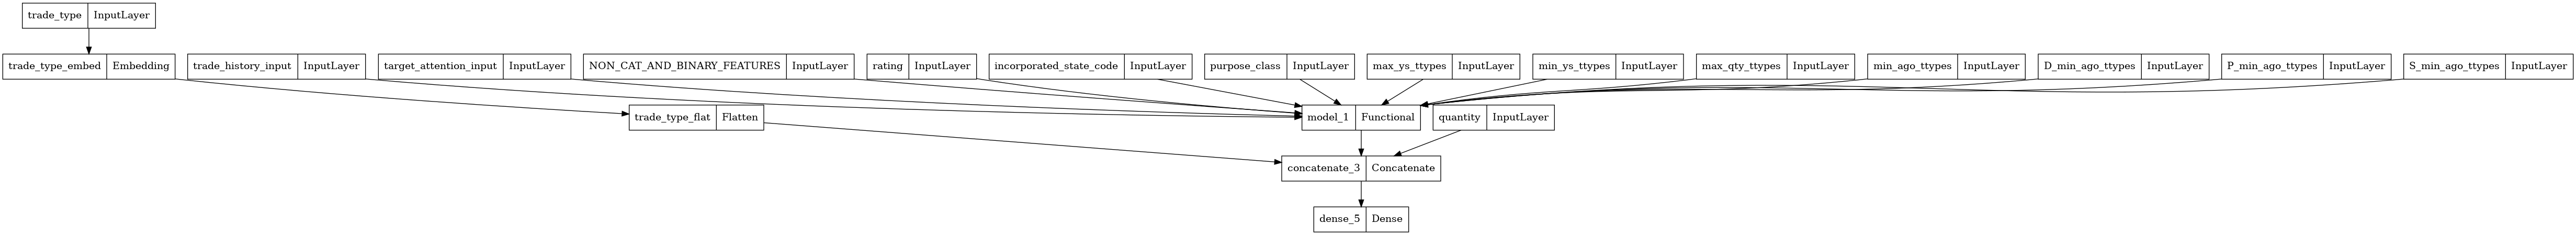

In [281]:
keras.utils.plot_model(final_model)

### Training new model

Single linear layer at the end

In [25]:
BATCH_SIZE = 10000
LEARNING_RATE = 0.0007

In [284]:
# shuffle_buffer = .75
# use_bottleneck_model = False
# NUM_EPOCHS = 150
# verbose = 1
# ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-26_11:09

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-26 18:09:52.090818: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-26 18:10:02.716481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 497731 of 2575773
2023-09-26 18:10:12.716462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 763327 of 2575773
2023-09-26 18

344/344 [==============================] - ETA: 0s - loss: 47.5855

2023-09-26 18:12:55.960047: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 213s 428ms/step - loss: 47.5855 - val_loss: 30.0502
Epoch 2/150
344/344 [==============================] - 25s 72ms/step - loss: 20.1656 - val_loss: 12.5057
Epoch 3/150
344/344 [==============================] - 27s 78ms/step - loss: 12.5550 - val_loss: 12.2274
Epoch 4/150
344/344 [==============================] - 25s 73ms/step - loss: 12.2004 - val_loss: 11.5701
Epoch 5/150
344/344 [==============================] - 28s 80ms/step - loss: 12.0071 - val_loss: 11.3725
Epoch 6/150
344/344 [==============================] - 25s 73ms/step - loss: 11.8565 - val_loss: 11.2510
Epoch 7/150
344/344 [==============================] - 27s 77ms/step - loss: 11.7484 - val_loss: 11.1059
Epoch 8/150
344/344 [==============================] - 26s 76ms/step - loss: 11.6619 - val_loss: 11.0593
Epoch 9/150
344/344 [==============================] - 26s 75ms/step - loss: 11.5908 - val_loss: 11.0405
Epoch 10/150
344/344 [==============================] - 27s 78ms/

2023-09-26 18:58:42.340616: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 9.944591696178511 =========================
experiments/cross_market/new_ys_experiment_2023-09-26_11:09 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_11:09/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_11:09/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-26_11:09/model/model_0


INFO:tensorflow:Assets written to: ram://03b12e5e-5fc9-4481-8520-c666f28defa7/assets


INFO:tensorflow:Assets written to: ram://03b12e5e-5fc9-4481-8520-c666f28defa7/assets


In [27]:
newmodel = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-09-26_11:09/model/model_0')

In [58]:
test_dataframe['prediction']  = newmodel.predict(x_test, batch_size=BATCH_SIZE).flatten()

In [60]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,9.945,5.102,727866
1.5% <= last yld <= 7%,9.804,5.212,661276
1.5% <= last yld <= 7% & when issued,3.837,2.208,42472
no last yld,28.063,15.591,3634
last yld < 1.5%,37.525,16.373,1864
last yld > 7%,114.958,24.092,1583
no last yld & when issued,13.983,10.557,17020
last yld > 7% & when issued,19.970,18.496,17


======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,8.128,4.844,662617
1.5% <= last yld <= 7%,8.150,4.959,598765
1.5% <= last yld <= 7% & when issued,3.821,2.207,42409
last yld < 1.5%,17.972,11.826,1155
no last yld,21.505,13.603,2609
last yld > 7%,44.366,14.462,672
no last yld & when issued,13.943,10.534,16990
last yld > 7% & when issued,19.970,18.496,17


In [28]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'].sort_values('trade_datetime', ascending=True)
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [41]:
synthetic_test['maturity'] = synthetic_test[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
synthetic_test['maturity_bucket'] = pd.cut(synthetic_test['maturity'], [0, 5, 10, 15, 20, 30, synthetic_test.maturity.max()])

In [42]:
synthetic_x_test = create_input_2(synthetic_test, trade_history_col, yield_history_cols)
pred  = newmodel.predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction'] = pred

2023-09-26 20:25:28.540120: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-26 20:25:29.996352: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


In [105]:
encoded_ttypes = newmodel.layers[14](encoders['trade_type'].transform(test_dataframe.trade_type.unique())).numpy()
w = newmodel.layers[-1].weights[0].numpy()[1:-1].reshape(-1,)
np.sum(encoded_ttypes*w, axis=1)

array([21.817316, 25.547747, 23.918587], dtype=float32)

In [106]:
25.547747 - 21.817316

3.7304309999999994

In [44]:
summary_df = make_summary(synthetic_test)
summary_df = summary_df.reset_index()

In [50]:
summary_df

,cusip,Diff,Cross,rtrs_control_number,yield,is_callable,refund_date,accrual_date,dated_date,next_sink_date,...,S_min_ago_ago,S_min_ago_qdiff,ttypes,diff_size,last_yield_spread_missing,last_seconds_ago_missing,trade_history_shortened,maturity,maturity_bucket,prediction
0,00037CUQ1,3.730,False,2023073105932700,540.600,True,NaT,2013-06-06,2013-06-06,2024-11-15,...,2.903,5.000,PP,25000.000,False,False,"[[208.97208594759996, 143.6, 4.397940158843994...",12.286,"(10.0, 15.0]",207.650
1,00037CUQ1,3.730,False,2023073105932700,540.600,True,NaT,2013-06-06,2013-06-06,2024-11-15,...,2.903,5.000,PP,25000.000,False,False,"[[208.97208594759996, 143.6, 4.397940158843994...",12.286,"(10.0, 15.0]",203.920
2,00037CVM9,3.730,False,2023070707274800,346.600,True,NaT,2014-02-12,2014-02-12,NaT,...,4.880,4.398,DS,0.000,False,False,"[[-10.212505171072507, -194.4, 4.3979401588439...",11.056,"(10.0, 15.0]",-11.187
3,00037CVM9,3.730,False,2023070707274800,346.600,True,NaT,2014-02-12,2014-02-12,NaT,...,4.880,4.398,DS,0.000,False,False,"[[-10.212505171072507, -194.4, 4.3979401588439...",11.056,"(10.0, 15.0]",-7.457
4,00037CVN7,3.730,False,2023071111075000,476.500,True,NaT,2014-02-12,2014-02-12,2040-08-01,...,6.629,4.398,DP,-25000.000,False,False,"[[-89.17595002200903, -209.8, 4.69896984100341...",20.050,"(20.0, 30.0]",134.489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245711,98972LPP0,3.730,False,2023070508893200,379.700,True,NaT,2021-11-30,2021-11-30,2036-01-15,...,7.652,0.000,PP,0.000,False,False,"[[80.18328079243156, 41.1, 4.698969841003418, ...",13.022,"(10.0, 15.0]",97.206
245712,989781BB4,3.730,False,2023072409446100,440.100,True,NaT,2021-05-13,2021-05-13,2039-02-01,...,3.954,0.000,DP,0.000,False,False,"[[80.17242510776867, 27.0, 4.397940158843994, ...",17.514,"(15.0, 20.0]",81.783
245713,989781BB4,3.730,False,2023072409446100,440.100,True,NaT,2021-05-13,2021-05-13,2039-02-01,...,3.954,0.000,DP,0.000,False,False,"[[80.17242510776867, 27.0, 4.397940158843994, ...",17.514,"(15.0, 20.0]",78.053
245714,989786EQ7,3.730,False,2023072807026300,311.300,False,NaT,2020-02-06,2020-02-06,NaT,...,6.882,4.544,DS,0.000,False,False,"[[14.648727204538147, -120.4, 4.17609119415283...",3.500,"(0.0, 5.0]",3.663


In [ ]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

Additional dense layer at the end with relu activation:
- recall: any sequence of dense layers with linear activations is reducible to a single linear layer, so having a linear activation is pointless in achieving our intended goal of introducing complexity.

In [130]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-26_15:07

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-26 22:07:56.938180: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-26 22:08:07.587174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 397969 of 2575773
2023-09-26 22:08:17.587179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 664588 of 2575773
2023-09-26 22

344/344 [==============================] - ETA: 0s - loss: 54.0331

2023-09-26 22:10:53.661294: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 192s 381ms/step - loss: 54.0331 - val_loss: 52.8234
Epoch 2/150
344/344 [==============================] - 24s 70ms/step - loss: 35.5773 - val_loss: 29.0034
Epoch 3/150
344/344 [==============================] - 26s 77ms/step - loss: 12.7118 - val_loss: 12.3890
Epoch 4/150
344/344 [==============================] - 26s 76ms/step - loss: 12.2318 - val_loss: 12.1008
Epoch 5/150
344/344 [==============================] - 26s 75ms/step - loss: 12.0004 - val_loss: 11.8062
Epoch 6/150
344/344 [==============================] - 27s 77ms/step - loss: 11.8376 - val_loss: 11.5630
Epoch 7/150
344/344 [==============================] - 25s 72ms/step - loss: 11.7266 - val_loss: 11.0459
Epoch 8/150
344/344 [==============================] - 27s 79ms/step - loss: 11.6283 - val_loss: 11.1134
Epoch 9/150
344/344 [==============================] - 25s 72ms/step - loss: 11.5428 - val_loss: 11.1194
Epoch 10/150
344/344 [==============================] - 27s 79ms/

2023-09-26 22:43:45.874080: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 9.97300681671543 =========================
experiments/cross_market/new_ys_experiment_2023-09-26_15:07 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_15:07/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_15:07/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-26_15:07/model/model_0


INFO:tensorflow:Assets written to: ram://b1c7fd7d-75ad-4b5a-94ae-f83a11affb64/assets


INFO:tensorflow:Assets written to: ram://b1c7fd7d-75ad-4b5a-94ae-f83a11affb64/assets


In [131]:
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_2'] = pred

In [132]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_2')
summary_df = summary_df.reset_index()

In [141]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

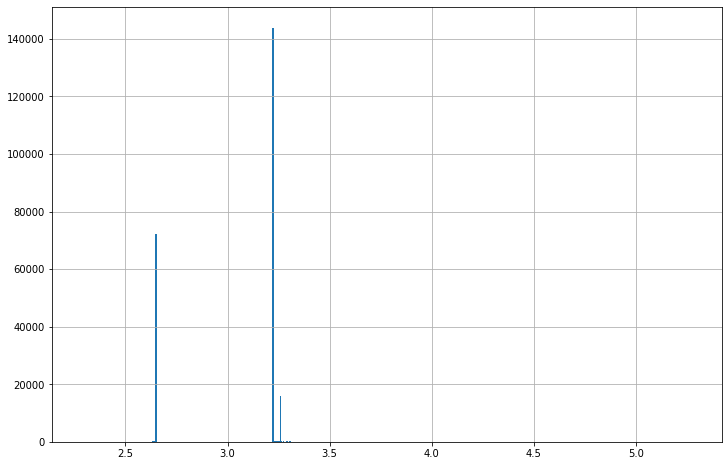

In [139]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

2 dense layers at the end (25,10)

In [155]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-26_23:33

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-27 06:33:18.876077: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-27 06:33:29.514478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 564849 of 2575773
2023-09-27 06:33:39.514485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1130741 of 2575773
2023-09-27 0

344/344 [==============================] - ETA: 0s - loss: 28.4429

2023-09-27 06:36:15.212398: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 198s 395ms/step - loss: 28.4429 - val_loss: 14.3608
Epoch 2/150
344/344 [==============================] - 24s 70ms/step - loss: 12.9420 - val_loss: 12.1751
Epoch 3/150
344/344 [==============================] - 27s 79ms/step - loss: 12.4711 - val_loss: 11.7186
Epoch 4/150
344/344 [==============================] - 25s 73ms/step - loss: 12.2064 - val_loss: 11.6492
Epoch 5/150
344/344 [==============================] - 27s 77ms/step - loss: 12.0246 - val_loss: 11.4307
Epoch 6/150
344/344 [==============================] - 25s 74ms/step - loss: 11.8881 - val_loss: 11.2964
Epoch 7/150
344/344 [==============================] - 26s 74ms/step - loss: 11.7803 - val_loss: 11.1820
Epoch 8/150
344/344 [==============================] - 27s 77ms/step - loss: 11.6810 - val_loss: 11.1412
Epoch 9/150
344/344 [==============================] - 25s 72ms/step - loss: 11.5997 - val_loss: 11.0806
Epoch 10/150
344/344 [==============================] - 27s 78ms/

2023-09-27 07:33:14.685878: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 9.902264380285715 =========================
experiments/cross_market/new_ys_experiment_2023-09-26_23:33 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_23:33/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_23:33/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-26_23:33/model/model_0


INFO:tensorflow:Assets written to: ram://c52f0dbb-d666-43c0-88c8-cd7212981e65/assets


INFO:tensorflow:Assets written to: ram://c52f0dbb-d666-43c0-88c8-cd7212981e65/assets


In [157]:
synthetic_x_test = create_input_2(synthetic_test, trade_history_col, yield_history_cols)


In [160]:
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_4'] = pred

In [161]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_4')
summary_df = summary_df.reset_index()

In [162]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

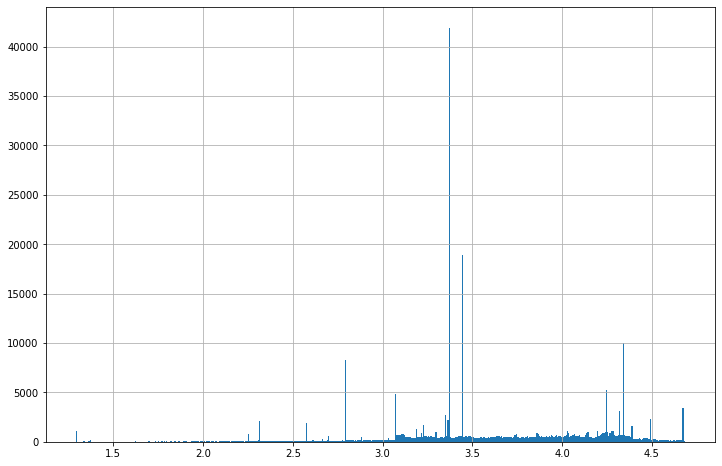

In [163]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

2 dense layers at the end (50, 25):

In [165]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-27_00:40

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-27 07:40:27.811895: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-27 07:40:38.441808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 570972 of 2575773
2023-09-27 07:40:48.441804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1143099 of 2575773
2023-09-27 0

344/344 [==============================] - ETA: 0s - loss: 24.8149

2023-09-27 07:43:22.103244: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 189s 372ms/step - loss: 24.8149 - val_loss: 14.0875
Epoch 2/150
344/344 [==============================] - 24s 70ms/step - loss: 12.9181 - val_loss: 12.1112
Epoch 3/150
344/344 [==============================] - 27s 79ms/step - loss: 12.5037 - val_loss: 11.7003
Epoch 4/150
344/344 [==============================] - 25s 73ms/step - loss: 12.2544 - val_loss: 11.6094
Epoch 5/150
344/344 [==============================] - 27s 80ms/step - loss: 12.0800 - val_loss: 11.4635
Epoch 6/150
344/344 [==============================] - 25s 72ms/step - loss: 11.9393 - val_loss: 11.3791
Epoch 7/150
344/344 [==============================] - 26s 76ms/step - loss: 11.8216 - val_loss: 11.2391
Epoch 8/150
344/344 [==============================] - 26s 76ms/step - loss: 11.7219 - val_loss: 11.1767
Epoch 9/150
344/344 [==============================] - 25s 74ms/step - loss: 11.6334 - val_loss: 11.1315
Epoch 10/150
344/344 [==============================] - 27s 78ms/

2023-09-27 08:13:22.322803: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 9.90976473681359 =========================
experiments/cross_market/new_ys_experiment_2023-09-27_00:40 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_00:40/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_00:40/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-27_00:40/model/model_0


INFO:tensorflow:Assets written to: ram://24259e88-710a-441e-87ed-74a86acd9bee/assets


INFO:tensorflow:Assets written to: ram://24259e88-710a-441e-87ed-74a86acd9bee/assets


In [166]:
synthetic_x_test = create_input_2(synthetic_test, trade_history_col, yield_history_cols)

In [168]:
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_5'] = pred

In [169]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_5')
summary_df = summary_df.reset_index()

In [170]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

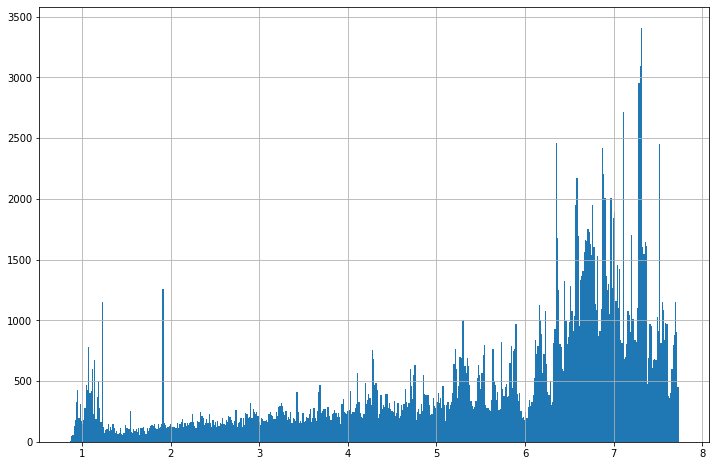

In [171]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

3 dense layers at the end (50, 25, 10):

In [183]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-27_12:10

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-27 19:10:54.768104: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-27 19:11:05.417937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 435714 of 2575773
2023-09-27 19:11:15.417939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 705718 of 2575773
2023-09-27 19

344/344 [==============================] - ETA: 0s - loss: 23.9536

2023-09-27 19:13:53.433172: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 193s 384ms/step - loss: 23.9536 - val_loss: 14.7221
Epoch 2/150
344/344 [==============================] - 24s 70ms/step - loss: 13.2157 - val_loss: 12.6367
Epoch 3/150
344/344 [==============================] - 25s 74ms/step - loss: 12.7391 - val_loss: 12.1217
Epoch 4/150
344/344 [==============================] - 26s 76ms/step - loss: 12.4710 - val_loss: 11.8281
Epoch 5/150
344/344 [==============================] - 25s 73ms/step - loss: 12.2800 - val_loss: 11.6595
Epoch 6/150
344/344 [==============================] - 27s 79ms/step - loss: 12.1205 - val_loss: 11.5122
Epoch 7/150
344/344 [==============================] - 25s 72ms/step - loss: 12.0097 - val_loss: 11.3944
Epoch 8/150
344/344 [==============================] - 27s 79ms/step - loss: 11.9058 - val_loss: 11.2848
Epoch 9/150
344/344 [==============================] - 25s 72ms/step - loss: 11.8184 - val_loss: 11.3136
Epoch 10/150
344/344 [==============================] - 26s 77ms/

2023-09-27 20:11:17.722635: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.041919406504956 =========================
experiments/cross_market/new_ys_experiment_2023-09-27_12:10 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_12:10/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_12:10/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-27_12:10/model/model_0


INFO:tensorflow:Assets written to: ram://7db92d0b-1752-4d26-9ba5-e7672b428bd6/assets


INFO:tensorflow:Assets written to: ram://7db92d0b-1752-4d26-9ba5-e7672b428bd6/assets


In [184]:
synthetic_x_test = create_input_2(synthetic_test, trade_history_col, yield_history_cols)

In [185]:
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_7'] = pred

2023-09-27 20:12:24.921195: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [190]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_7')
summary_df = summary_df.reset_index()

In [191]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

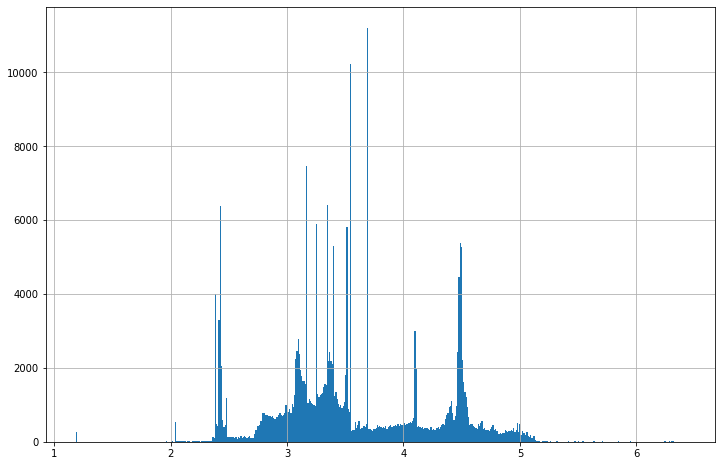

In [192]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

### Adding rating

In [172]:
def create_input_3(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    for f in ['trade_type', 'rating']:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
        
    noncat_and_binary = []
    for f in ['quantity']:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
        
    return datalist


def create_data_set_and_model_3(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_3(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_3(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_3(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def train_model_3(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1, use_bottleneck_model = False):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    if use_bottleneck_model:
        basemodel = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                                   yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    else:
        basemodel = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    
    inputs = []
    embeds = []
    for f in ['trade_type', 'rating']:
        inputlayer = keras.layers.Input(shape=(1,), name=f)
        embed = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                                output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                                input_length= 1,
                                                                                name = f + "_embed")(inputlayer))
        inputs.append(inputlayer)
        embeds.append(embed)
    
    qty_input = keras.layers.Input(shape=(1,), name='quantity')
    final_output = layers.Dense(50,activation='relu',)(layers.concatenate([basemodel(basemodel.input)] + embeds + [qty_input]))
    final_output = layers.Dense(25,activation='relu',)(layers.concatenate([basemodel(basemodel.input)] + embeds + [qty_input]))
    final_output = layers.Dense(1)(final_output)
    final_model = keras.Model(inputs=[basemodel.inputs] + inputs + [qty_input], outputs=final_output)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())

    history= final_model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, final_model

def run_experiment_3(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_3(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer, use_bottleneck_model=False)
        pred = model.predict(x_test, batch_size=5000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [173]:
modify_features(['trade_type_numeric', 'quantity'], 'remove', 'numeric')
modify_features(['trade_type', 'rating'], 'remove', 'categorical')

In [145]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_3(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-26_15:57

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-26 22:57:23.843802: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-26 22:57:34.482677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 561223 of 2575773
2023-09-26 22:57:44.482670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1119027 of 2575773
2023-09-26 2

344/344 [==============================] - ETA: 0s - loss: 53.9809

2023-09-26 23:00:21.974964: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 193s 382ms/step - loss: 53.9809 - val_loss: 52.4110
Epoch 2/150
344/344 [==============================] - 24s 70ms/step - loss: 35.0041 - val_loss: 38.9497
Epoch 3/150
344/344 [==============================] - 27s 78ms/step - loss: 12.8224 - val_loss: 12.7261
Epoch 4/150
344/344 [==============================] - 25s 73ms/step - loss: 12.2998 - val_loss: 11.7838
Epoch 5/150
344/344 [==============================] - 27s 78ms/step - loss: 12.0589 - val_loss: 12.0509
Epoch 6/150
344/344 [==============================] - 25s 72ms/step - loss: 11.8985 - val_loss: 11.7647
Epoch 7/150
344/344 [==============================] - 26s 76ms/step - loss: 11.7789 - val_loss: 11.3473
Epoch 8/150
344/344 [==============================] - 26s 77ms/step - loss: 11.6902 - val_loss: 11.4790
Epoch 9/150
344/344 [==============================] - 25s 72ms/step - loss: 11.6147 - val_loss: 11.1703
Epoch 10/150
344/344 [==============================] - 27s 78ms/

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



344/344 [==============================] - 25s 72ms/step - loss: 10.9205 - val_loss: 10.5219
Epoch 31/150
344/344 [==============================] - 27s 79ms/step - loss: 10.8998 - val_loss: 10.4795
Epoch 32/150
344/344 [==============================] - 25s 72ms/step - loss: 10.8832 - val_loss: 10.5065
Epoch 33/150
344/344 [==============================] - 27s 78ms/step - loss: 10.8731 - val_loss: 10.4689
Epoch 34/150
344/344 [==============================] - 25s 72ms/step - loss: 10.8516 - val_loss: 10.5379
Epoch 35/150
344/344 [==============================] - 27s 77ms/step - loss: 10.8355 - val_loss: 10.4042
Epoch 36/150
344/344 [==============================] - 25s 72ms/step - loss: 10.8212 - val_loss: 10.4285
Epoch 37/150
344/344 [==============================] - 27s 79ms/step - loss: 10.8084 - val_loss: 10.4687
Epoch 38/150
344/344 [==============================] - 25s 72ms/step - loss: 10.7937 - val_loss: 10.4490
Epoch 39/150
344/344 [==============================] - 26s

2023-09-26 23:44:44.762851: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.002416169152141 =========================
experiments/cross_market/new_ys_experiment_2023-09-26_15:57 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_15:57/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-26_15:57/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-26_15:57/model/model_0


INFO:tensorflow:Assets written to: ram://f7ac0fac-667f-4bbc-bee4-4474243bf23d/assets


INFO:tensorflow:Assets written to: ram://f7ac0fac-667f-4bbc-bee4-4474243bf23d/assets


In [146]:
synthetic_x_test = create_input_3(synthetic_test, trade_history_col, yield_history_cols)
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_3'] = pred

In [147]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_3')
summary_df = summary_df.reset_index()

In [148]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

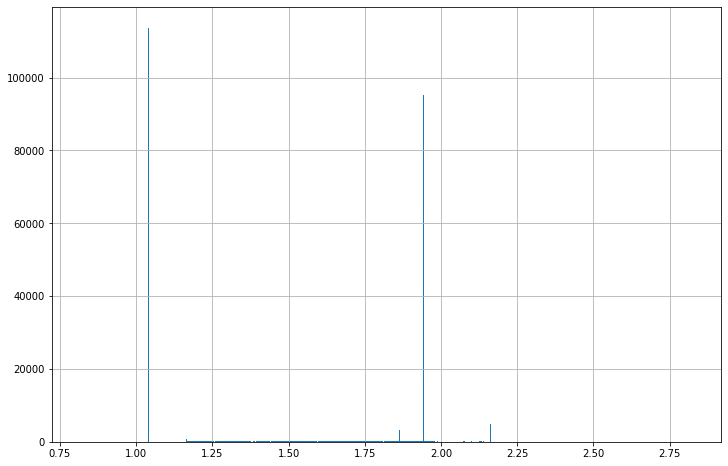

In [149]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

In [175]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_3(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-27_10:34

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-09-27 17:34:42.508732: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-27 17:34:53.154822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 552154 of 2575773
2023-09-27 17:35:03.154855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1061645 of 2575773
2023-09-27 1

344/344 [==============================] - ETA: 0s - loss: 31.4955

2023-09-27 17:37:41.523904: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 193s 384ms/step - loss: 31.4955 - val_loss: 29.1503
Epoch 2/150
344/344 [==============================] - 27s 77ms/step - loss: 13.0918 - val_loss: 12.4935
Epoch 3/150
344/344 [==============================] - 25s 72ms/step - loss: 12.5892 - val_loss: 12.0416
Epoch 4/150
344/344 [==============================] - 26s 77ms/step - loss: 12.3217 - val_loss: 11.8563
Epoch 5/150
344/344 [==============================] - 26s 75ms/step - loss: 12.1341 - val_loss: 11.5671
Epoch 6/150
344/344 [==============================] - 25s 73ms/step - loss: 11.9987 - val_loss: 11.3928
Epoch 7/150
344/344 [==============================] - 27s 77ms/step - loss: 11.8810 - val_loss: 11.3447
Epoch 8/150
344/344 [==============================] - 25s 73ms/step - loss: 11.7873 - val_loss: 11.2430
Epoch 9/150
344/344 [==============================] - 27s 78ms/step - loss: 11.7022 - val_loss: 11.1535
Epoch 10/150
344/344 [==============================] - 25s 72ms/

2023-09-27 18:34:12.591115: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.01231630014323 =========================
experiments/cross_market/new_ys_experiment_2023-09-27_10:34 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_10:34/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-27_10:34/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-27_10:34/model/model_0


INFO:tensorflow:Assets written to: ram://cb9e2fba-23dd-4e1d-9db8-121949bc93cf/assets


INFO:tensorflow:Assets written to: ram://cb9e2fba-23dd-4e1d-9db8-121949bc93cf/assets


In [176]:
synthetic_x_test = create_input_3(synthetic_test, trade_history_col, yield_history_cols)
pred  = ytw_result[0][1].predict(synthetic_x_test, batch_size=BATCH_SIZE).flatten()
synthetic_test['prediction_6'] = pred

In [177]:
summary_df = make_summary(synthetic_test, prediction_col='prediction_6')
summary_df = summary_df.reset_index()

In [178]:
(summary_df.Diff < 0).sum()

0

<AxesSubplot:>

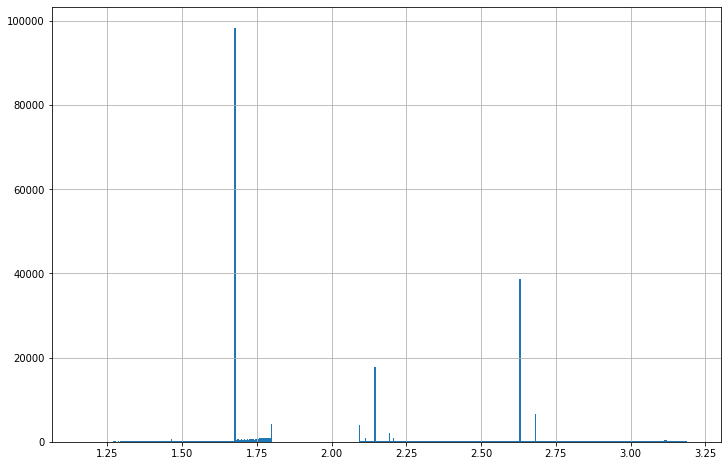

In [179]:
summary_df['Diff'].hist(bins=500, figsize=(12,8))

Comparing all results:

trade and qty models:

In [194]:
model_paths = ['experiments/cross_market/new_ys_experiment_2023-09-26_11:09',  #0 additional dense layers at the end
                'experiments/cross_market/new_ys_experiment_2023-09-26_15:07', #1 additional dense layer at the end (10)
                'experiments/cross_market/new_ys_experiment_2023-09-26_23:33', #2 additional dense layers at the end (25, 10)
                'experiments/cross_market/new_ys_experiment_2023-09-27_00:40', #3 additional dense layers at the end (50, 25)
                'experiments/cross_market/new_ys_experiment_2023-09-27_12:10'  #4 additional dense layers at the end (50, 25, 10)
              ] 
models = [] 
for path in model_paths:
    models.append(keras.models.load_model(os.path.join(path, 'model/model_0')))

In [205]:
# CATEGORICAL_FEATURES = ['rating',
#                         'incorporated_state_code',
#                              'purpose_class',
#                              'max_ys_ttypes',
#                              'min_ys_ttypes',
#                              'max_qty_ttypes',
#                              'min_ago_ttypes',
#                              'D_min_ago_ttypes',
#                              'P_min_ago_ttypes',
#                              'S_min_ago_ttypes']

In [207]:
x_test_2 = create_input_2(test_dataframe, trade_history_col, yield_history_cols)
pred_cols = []
for i, m in enumerate(models):
    col = f'prediction_{i}'
    test_dataframe[col] = m.predict(x_test_2, batch_size=5000)
    pred_cols.append(col)

2023-09-27 21:33:44.284350: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-27 21:33:47.928912: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [209]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = pred_cols, 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = pred_cols,   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_0 has 0 nan values
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values
Prediction col prediction_4 has 0 nan values


MAE                            \
                                     prediction_0 prediction_1 prediction_2   
Overall                                     9.945        9.973        9.902   
1.5% <= last yld <= 7%                      9.804        9.830        9.771   
1.5% <= last yld <= 7% & when issued        3.837        3.859        3.755   
no last yld                                28.063       27.344       27.989   
last yld < 1.5%                            37.525       35.853       36.915   
last yld > 7%                             114.958      114.313      119.459   
no last yld & when issued                  13.983       14.544       13.321   
last yld > 7% & when issued                19.970       22.715       26.905   

                                                                        MAD  \
                                     prediction_3 prediction_4 prediction_0   
Overall                                     9.910       10.042        5.102   
1.5% <= last yld <= 7%                      9.797        9.889        5.212   
1.5% <= last yld <= 7% & when issued        3.842        3.739        2.208   
no last yld                                27.611       27.180       15.591   
last yld < 1.5%                            36.902       37.806       16.373   
last yld > 7%                             111.589      111.658       24.092   
no last yld & when issued                  13.225       15.540       10.557   
last yld > 7% & when issued                27.405       26.487       18.496   

                                                                             \
                                     prediction_1 prediction_2 prediction_3   
Overall                                     5.124        5.023        5.082   
1.5% <= last yld <= 7%                      5.234        5.146        5.203   
1.5% <= last yld <= 7% & when issued        2.219        2.080        2.142   
no last yld                                15.213       15.268       14.663   
last yld < 1.5%                            16.551       15.723       16.405   
last yld > 7%                              22.648       22.599       21.164   
no last yld & when issued                  10.892        9.951       10.106   
last yld > 7% & when issued                17.523        9.243       17.185   

                                                           
                                     prediction_4       N  
Overall                                     5.127  727866  
1.5% <= last yld <= 7%                      5.245  661276  
1.5% <= last yld <= 7% & when issued        2.011   42472  
no last yld                                14.552    3634  
last yld < 1.5%                            16.470    1864  
last yld > 7%                              23.640    1583  
no last yld & when issued                  11.291   17020  
last yld > 7% & when issued                17.431      17

======================= Analysis for target: new_ys =======================
Prediction col prediction_0 has 0 nan values
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values
Prediction col prediction_4 has 0 nan values


MAE                            \
                                     prediction_0 prediction_1 prediction_2   
Overall                                     8.128        8.153        8.043   
1.5% <= last yld <= 7%                      8.150        8.163        8.082   
1.5% <= last yld <= 7% & when issued        3.821        3.846        3.740   
last yld < 1.5%                            17.972       18.979       16.914   
no last yld                                21.505       21.489       22.022   
last yld > 7%                              44.366       39.715       42.254   
no last yld & when issued                  13.943       14.514       13.293   
last yld > 7% & when issued                19.970       22.715       26.905   

                                                                        MAD  \
                                     prediction_3 prediction_4 prediction_0   
Overall                                     8.118        8.219        4.844   
1.5% <= last yld <= 7%                      8.161        8.214        4.959   
1.5% <= last yld <= 7% & when issued        3.827        3.725        2.207   
last yld < 1.5%                            18.376       18.892       11.826   
no last yld                                21.691       21.208       13.603   
last yld > 7%                              41.596       42.403       14.462   
no last yld & when issued                  13.181       15.518       10.534   
last yld > 7% & when issued                27.405       26.487       18.496   

                                                                             \
                                     prediction_1 prediction_2 prediction_3   
Overall                                     4.854        4.757        4.816   
1.5% <= last yld <= 7%                      4.969        4.883        4.942   
1.5% <= last yld <= 7% & when issued        2.219        2.080        2.141   
last yld < 1.5%                            13.338       10.906       12.727   
no last yld                                13.595       13.795       13.189   
last yld > 7%                              15.318       15.063       14.194   
no last yld & when issued                  10.881        9.929       10.098   
last yld > 7% & when issued                17.523        9.243       17.185   

                                                           
                                     prediction_4       N  
Overall                                     4.862  662617  
1.5% <= last yld <= 7%                      4.983  598765  
1.5% <= last yld <= 7% & when issued        2.009   42409  
last yld < 1.5%                            12.457    1155  
no last yld                                13.515    2609  
last yld > 7%                              14.801     672  
no last yld & when issued                  11.277   16990  
last yld > 7% & when issued                17.431      17

In [234]:
synthetic_test_LARGE = test_dataframe[test_dataframe.trade_type!='D'].sort_values('trade_datetime', ascending=True)
synthetic_test_LARGE = synthetic_test_LARGE.drop_duplicates(subset=['rtrs_control_number'], keep='last')
temp = synthetic_test_LARGE.copy()
temp.trade_type = ['S' if x == 'P' else 'P' for x in temp.trade_type]
synthetic_test_LARGE = pd.concat([synthetic_test_LARGE, temp], axis=0)
synthetic_test_LARGE.reset_index(inplace=True, drop=True)

In [353]:
synthetic_test_LARGE.quantity = np.log10(25000)

In [354]:
syn_x_test_2 = create_input_2(synthetic_test_LARGE, trade_history_col, yield_history_cols)
pred_cols = []
for i, m in enumerate(models):
    col = f'prediction_{i}'
    synthetic_test_LARGE[col] = m.predict(syn_x_test_2, batch_size=5000)
    pred_cols.append(col)

In [355]:
synthetic_test_LARGE.quantity

0        4.398
1        4.398
2        4.398
3        4.398
4        4.398
          ... 
880817   4.398
880818   4.398
880819   4.398
880820   4.398
880821   4.398
Name: quantity, Length: 880822, dtype: float64

In [356]:
p = pd.pivot_table(synthetic_test_LARGE,
              values=pred_cols,
              index='rtrs_control_number',
              columns='trade_type')
diff_cols = [f'diff_{i}' for i in range(len(pred_cols))]
p[diff_cols] = p.diff(-1, axis = 1).values[:, ::2]

In [357]:
(p[diff_cols] < 0).sum()

        trade_type
diff_0                    0
diff_1                    0
diff_2                    0
diff_3                    0
diff_4                65280
dtype: int64

<AxesSubplot:>

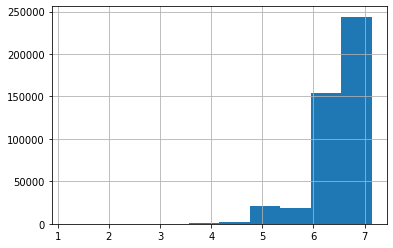

In [358]:
p.diff_3.hist()

<AxesSubplot:xlabel='quantity', ylabel='diff_3'>

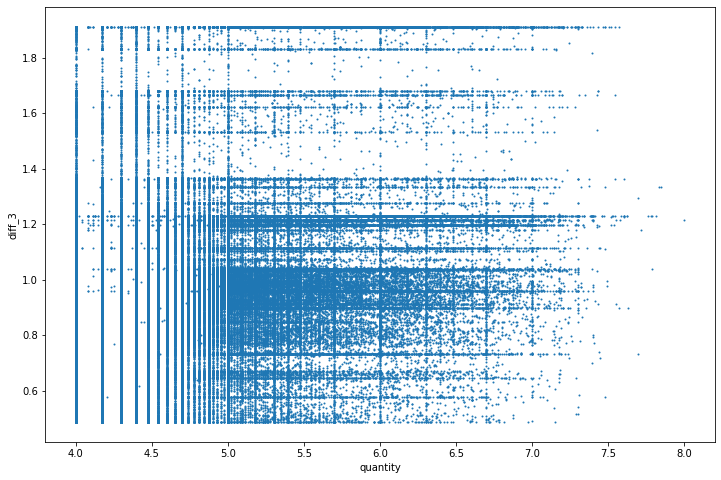

In [326]:
test_dataframe.set_index('rtrs_control_number').join(p['diff_3'])[['quantity', 'diff_3']].plot('quantity', 'diff_3' , kind='scatter', figsize=(12,8), s=1)

In [ ]:
test_dataframe.set_index('rtrs_control_number').join(p['diff_3']).groupby('rating')['diff_3'].mean().sort_values()

rating
CCC-   4.295
BB-    5.017
NR     5.133
BB     5.148
AAA    5.203
BB+    5.251
B      5.287
AA+    5.406
AA-    5.435
B-     5.489
MR     5.499
AA     5.628
A+     5.636
CCC    5.747
A      5.804
BBB    5.891
A-     5.917
BBB-   5.923
B+     5.958
BBB+   5.971
CCC+   5.979
CC     6.168
Name: diff_3, dtype: float32

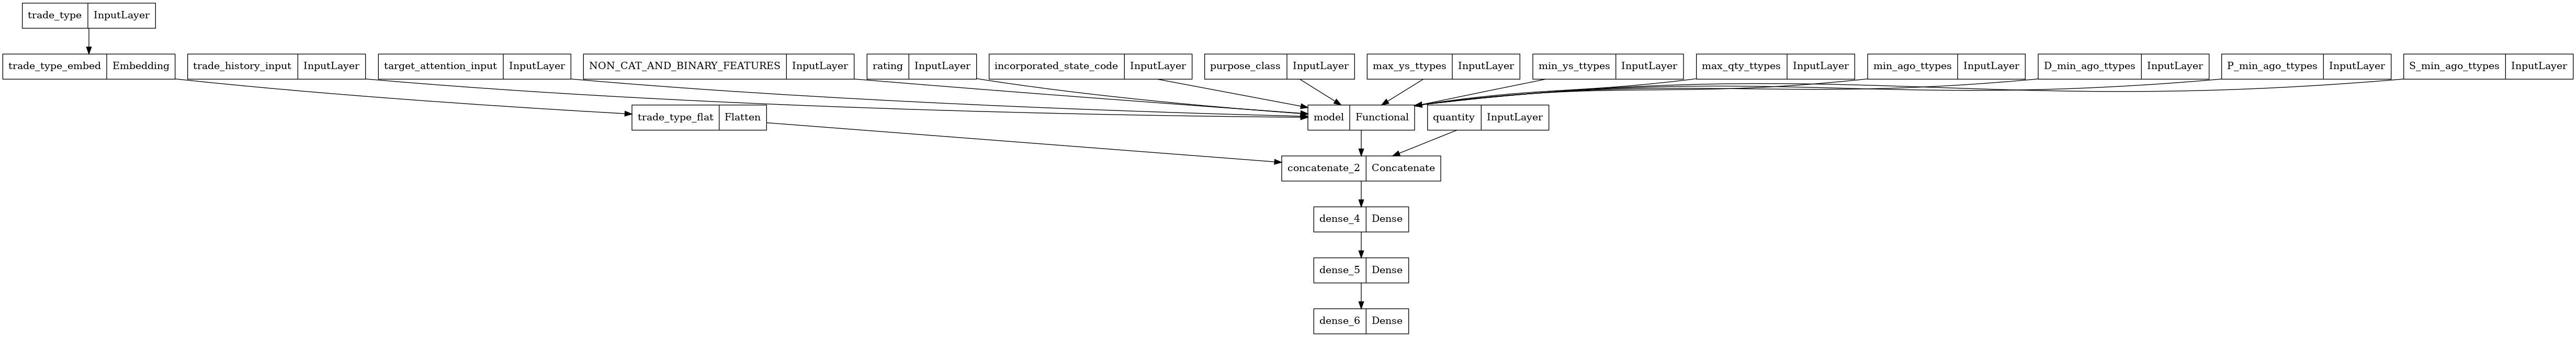

In [293]:
keras.utils.plot_model(models[2])

In [67]:
def check_cross(df, prediction_col = 'prediction'):
    try:
            P_yield = df[df.trade_type=='P'][prediction_col].values[0]
            S_yield = df[df.trade_type=='S'][prediction_col].values[0]
        
            diff = P_yield - S_yield
        
            return [diff, diff <= 0]
    except Exception as e:
        print(e, df.cusip)
        
def make_summary(df, groupbycol = 'cusip', prediction_col = 'prediction', output_col = 'Cross'):
    '''Calculates the Max-Min range by cusip'''
    print(f'Prediction col: {prediction_col}')
    x = df.groupby(groupbycol).parallel_apply(lambda x: check_cross(x, prediction_col))
    summary_df = pd.DataFrame(zip(*x.values)).T
    
    summary_df.index = x.index
    summary_df.columns = ['Diff','Cross']
    
    summary_df = summary_df.join(synthetic_test.set_index(groupbycol))
    
    return summary_df

In [360]:
test_dataframe.to_pickle('cross_market_comparison.pkl')

# Looking at Predicted Yield vs Qty

In [ ]:
model_paths = ['experiments/cross_market/new_ys_experiment_2023-09-26_11:09',  #0 additional dense layers at the end
                'experiments/cross_market/new_ys_experiment_2023-09-26_15:07', #1 additional dense layer at the end (10)
                'experiments/cross_market/new_ys_experiment_2023-09-26_23:33', #2 additional dense layers at the end (25, 10)
                'experiments/cross_market/new_ys_experiment_2023-09-27_00:40', #3 additional dense layers at the end (50, 25)
                'experiments/cross_market/new_ys_experiment_2023-09-27_12:10'  #4 additional dense layers at the end (50, 25, 10)
              ] 

In [108]:
model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-09-26_23:33/model/model_0')

In [59]:
# new_model = keras.models.load_model('gs://ahmad_data/model_new_architecture')
new_model = keras.models.load_model('gs://ahmad_data/model_new_architecture_no_batch_norm')

In [115]:
test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [153]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'][PREDICTORS+['cusip', 'trade_type', 'quantity', 'trade_datetime']].sort_values('trade_datetime', ascending=True).copy()
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [45]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [155]:
ttype_cols = [x for x in YS_COLS if 'ttypes' in x]

In [156]:
synthetic_test[['trade_type'] + ttype_cols]

,trade_type,max_ys_ttypes,min_ys_ttypes,max_qty_ttypes,min_ago_ttypes,D_min_ago_ttypes,P_min_ago_ttypes,S_min_ago_ttypes
0,S,SS,SS,PS,PS,DS,PS,SS
1,S,DS,DS,DS,DS,DS,PS,SS
2,S,DS,SS,SS,DS,DS,PS,SS
3,S,DS,SS,SS,DS,DS,PS,SS
4,S,PS,DS,DS,DS,DS,PS,SS
...,...,...,...,...,...,...,...,...
245711,P,PS,DS,DS,DS,DS,PS,SS
245712,P,PS,SS,DS,DS,DS,PS,SS
245713,P,PS,DS,DS,DS,DS,PS,SS
245714,P,DS,DS,DS,DS,DS,PS,DS


In [157]:
%%time
temp = synthetic_test[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
synthetic_test[YS_COLS] = pd.DataFrame(temp.tolist(), index=synthetic_test.index)

CPU times: user 8.36 s, sys: 8.27 s, total: 16.6 s
Wall time: 27.8 s


invert attention ttype

In [158]:
np.concatenate(synthetic_test.target_attention_features.values)[:, 1:].sum(axis=0)

array([ 67630., 172320.])

In [43]:
def invert_attention(arr):
    return arr[:, [0,2,1]]

In [160]:
inverted_attention = synthetic_test.target_attention_features.parallel_apply(invert_attention)

In [161]:
np.concatenate(inverted_attention.values)[:, 1:].sum(axis=0)

array([172320.,  67630.])

In [162]:
synthetic_test.target_attention_features = inverted_attention.values

In [163]:
modify_features(['trade_type_numeric', 'quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

In [165]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES+['trade_type']:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
trade_type


In [166]:
x_test_2 = create_input_2(synthetic_test, trade_history_col, yield_history_cols)

In [167]:
preds = new_model.predict(x_test_2, batch_size=20000)
preds2 = model.predict(x_test_2, batch_size=20000)

2023-09-29 23:29:23.526864: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-29 23:29:24.734221: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [168]:
synthetic_test['prediction'] = preds
synthetic_test['prediction2'] = preds2

In [169]:
summary_df = make_summary(synthetic_test, prediction_col='prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

13408

In [106]:
summary_df = make_summary(synthetic_test, prediction_col='prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

26110

In [107]:
summary_df = make_summary(synthetic_test, prediction_col='prediction2' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

5288

In [109]:
model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-09-26_23:33/model/model_0')
preds2 = model.predict(x_test_2, batch_size=20000)
synthetic_test['prediction2'] = preds2
summary_df = make_summary(synthetic_test, prediction_col='prediction2' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

2023-09-29 22:01:58.781773: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3794

In [111]:
model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-09-26_15:07/model/model_0')
preds2 = model.predict(x_test_2, batch_size=20000)
synthetic_test['prediction2'] = preds2
summary_df = make_summary(synthetic_test, prediction_col='prediction2' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

2023-09-29 22:04:08.551100: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3764

In [112]:
model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-09-26_11:09/model/model_0')
preds2 = model.predict(x_test_2, batch_size=20000)
synthetic_test['prediction2'] = preds2
summary_df = make_summary(synthetic_test, prediction_col='prediction2' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

2023-09-29 22:06:28.010055: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3700

Remove trade history ttypes

In [137]:
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [138]:
temp = train_dataframe[ttype_cols].applymap(lambda x: x[0])
train_dataframe[ttype_cols] = temp.values

temp = test_dataframe[ttype_cols].applymap(lambda x: x[0])
test_dataframe[ttype_cols] = temp.values

In [144]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES+['trade_type']:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(train_dataframe[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
trade_type


In [145]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, 
                                                                                                           yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [146]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

15
(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 47)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365, 1)


In [149]:
BATCH_SIZE = 1000
LEARNING_RATE = 0.0001

In [170]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-29_16:31

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0001, 'BATCH_SIZE': 1000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_ag

2023-09-29 23:31:23.648032: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-29 23:31:34.484426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 550952 of 2575773
2023-09-29 23:31:44.484423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1104512 of 2575773
2023-09-29 2

3435/3435 [==============================] - ETA: 0s - loss: 20.9813

2023-09-29 23:34:20.513428: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3435/3435 [==============================] - 191s 37ms/step - loss: 20.9813 - val_loss: 13.1550
Epoch 2/150
3435/3435 [==============================] - 66s 19ms/step - loss: 13.7467 - val_loss: 12.6352
Epoch 3/150
3435/3435 [==============================] - 65s 19ms/step - loss: 13.4000 - val_loss: 12.3675
Epoch 4/150
3435/3435 [==============================] - 65s 19ms/step - loss: 13.1718 - val_loss: 12.3948
Epoch 5/150
3435/3435 [==============================] - 67s 19ms/step - loss: 13.0033 - val_loss: 12.1621
Epoch 6/150
3435/3435 [==============================] - 66s 19ms/step - loss: 12.8605 - val_loss: 11.9897
Epoch 7/150
3435/3435 [==============================] - 71s 21ms/step - loss: 12.7415 - val_loss: 11.8956
Epoch 8/150
3435/3435 [==============================] - 69s 20ms/step - loss: 12.6454 - val_loss: 11.8219
Epoch 9/150
3435/3435 [==============================] - 65s 19ms/step - loss: 12.5558 - val_loss: 11.8132
Epoch 10/150
3435/3435 [========================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3435/3435 [==============================] - 64s 19ms/step - loss: 11.1017 - val_loss: 10.8314
Epoch 76/150
3435/3435 [==============================] - 63s 18ms/step - loss: 11.0969 - val_loss: 10.8570
Epoch 77/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0833 - val_loss: 10.8141
Epoch 78/150
1278/3435 [==========>...................] - ETA: 42s - loss: 11.0979

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3435/3435 [==============================] - 64s 19ms/step - loss: 11.0270 - val_loss: 10.7692
Epoch 85/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0229 - val_loss: 10.7922
Epoch 86/150
3435/3435 [==============================] - 63s 18ms/step - loss: 11.0174 - val_loss: 10.7958
Epoch 87/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0116 - val_loss: 10.7691
Epoch 88/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0030 - val_loss: 10.7538
Epoch 89/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9939 - val_loss: 10.7909
Epoch 90/150
3435/3435 [==============================] - 68s 20ms/step - loss: 10.9931 - val_loss: 10.7710
Epoch 91/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9854 - val_loss: 10.7594
Epoch 92/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9756 - val_loss: 10.8394
Epoch 93/150
3435/3435 [=================

2023-09-30 01:48:31.921845: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.604468472254377 =========================
experiments/cross_market/new_ys_experiment_2023-09-29_16:31 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0


INFO:tensorflow:Assets written to: ram://60dd8ffa-94e2-4b60-be10-2732a57594de/assets


INFO:tensorflow:Assets written to: ram://60dd8ffa-94e2-4b60-be10-2732a57594de/assets


In [176]:
test_dataframe['prediction'] = ytw_result[0][1].predict(x_test, batch_size=20000)

In [178]:
test_dataframe = addcol(test_dataframe, 'cases', mkcases(test_dataframe))

1.5% <= last yld <= 7%                  661276
1.5% <= last yld <= 7% & when issued     42472
no last yld & when issued                17020
no last yld                               3634
last yld < 1.5%                           1864
last yld > 7%                             1583
last yld > 7% & when issued                 17
dtype: int64


In [179]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,10.604,5.607,727866
1.5% <= last yld <= 7%,10.441,5.716,661276
1.5% <= last yld <= 7% & when issued,4.297,2.721,42472
no last yld,27.839,16.114,3634
last yld < 1.5%,40.509,18.529,1864
last yld > 7%,138.932,19.626,1583
no last yld & when issued,13.775,10.458,17020
last yld > 7% & when issued,32.935,12.257,17


======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,8.668,5.322,662617
1.5% <= last yld <= 7%,8.705,5.434,598765
1.5% <= last yld <= 7% & when issued,4.280,2.720,42409
last yld < 1.5%,21.682,14.051,1155
no last yld,21.570,14.192,2609
last yld > 7%,50.849,13.523,672
no last yld & when issued,13.730,10.446,16990
last yld > 7% & when issued,32.935,12.257,17


In [171]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'][PREDICTORS+['cusip', 'trade_type', 'quantity', 'trade_datetime']].sort_values('trade_datetime', ascending=True).copy()
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [172]:
x_test_2 = create_input_2(synthetic_test, trade_history_col, yield_history_cols)

In [173]:
preds = ytw_result[0][1].predict(x_test_2, batch_size=20000)

In [174]:
synthetic_test['prediction'] = preds


In [175]:
summary_df = make_summary(synthetic_test, prediction_col='prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

288

In [18]:
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [181]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES+['trade_type']:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(train_dataframe[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
trade_type


In [145]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, 
                                                                                                           yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [146]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

15
(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 47)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365, 1)


In [149]:
BATCH_SIZE = 1000
LEARNING_RATE = 0.0001

In [170]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
ytw_result = run_experiment_2(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-09-29_16:31

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0001, 'BATCH_SIZE': 1000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_ag

2023-09-29 23:31:23.648032: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-29 23:31:34.484426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 550952 of 2575773
2023-09-29 23:31:44.484423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1104512 of 2575773
2023-09-29 2

3435/3435 [==============================] - ETA: 0s - loss: 20.9813

2023-09-29 23:34:20.513428: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3435/3435 [==============================] - 191s 37ms/step - loss: 20.9813 - val_loss: 13.1550
Epoch 2/150
3435/3435 [==============================] - 66s 19ms/step - loss: 13.7467 - val_loss: 12.6352
Epoch 3/150
3435/3435 [==============================] - 65s 19ms/step - loss: 13.4000 - val_loss: 12.3675
Epoch 4/150
3435/3435 [==============================] - 65s 19ms/step - loss: 13.1718 - val_loss: 12.3948
Epoch 5/150
3435/3435 [==============================] - 67s 19ms/step - loss: 13.0033 - val_loss: 12.1621
Epoch 6/150
3435/3435 [==============================] - 66s 19ms/step - loss: 12.8605 - val_loss: 11.9897
Epoch 7/150
3435/3435 [==============================] - 71s 21ms/step - loss: 12.7415 - val_loss: 11.8956
Epoch 8/150
3435/3435 [==============================] - 69s 20ms/step - loss: 12.6454 - val_loss: 11.8219
Epoch 9/150
3435/3435 [==============================] - 65s 19ms/step - loss: 12.5558 - val_loss: 11.8132
Epoch 10/150
3435/3435 [========================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3435/3435 [==============================] - 64s 19ms/step - loss: 11.1017 - val_loss: 10.8314
Epoch 76/150
3435/3435 [==============================] - 63s 18ms/step - loss: 11.0969 - val_loss: 10.8570
Epoch 77/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0833 - val_loss: 10.8141
Epoch 78/150
1278/3435 [==========>...................] - ETA: 42s - loss: 11.0979

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3435/3435 [==============================] - 64s 19ms/step - loss: 11.0270 - val_loss: 10.7692
Epoch 85/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0229 - val_loss: 10.7922
Epoch 86/150
3435/3435 [==============================] - 63s 18ms/step - loss: 11.0174 - val_loss: 10.7958
Epoch 87/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0116 - val_loss: 10.7691
Epoch 88/150
3435/3435 [==============================] - 64s 19ms/step - loss: 11.0030 - val_loss: 10.7538
Epoch 89/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9939 - val_loss: 10.7909
Epoch 90/150
3435/3435 [==============================] - 68s 20ms/step - loss: 10.9931 - val_loss: 10.7710
Epoch 91/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9854 - val_loss: 10.7594
Epoch 92/150
3435/3435 [==============================] - 64s 19ms/step - loss: 10.9756 - val_loss: 10.8394
Epoch 93/150
3435/3435 [=================

2023-09-30 01:48:31.921845: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.604468472254377 =========================
experiments/cross_market/new_ys_experiment_2023-09-29_16:31 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-09-29_16:31/model/model_0


INFO:tensorflow:Assets written to: ram://60dd8ffa-94e2-4b60-be10-2732a57594de/assets


INFO:tensorflow:Assets written to: ram://60dd8ffa-94e2-4b60-be10-2732a57594de/assets


In [176]:
test_dataframe['prediction'] = ytw_result[0][1].predict(x_test, batch_size=20000)

In [178]:
test_dataframe = addcol(test_dataframe, 'cases', mkcases(test_dataframe))

1.5% <= last yld <= 7%                  661276
1.5% <= last yld <= 7% & when issued     42472
no last yld & when issued                17020
no last yld                               3634
last yld < 1.5%                           1864
last yld > 7%                             1583
last yld > 7% & when issued                 17
dtype: int64


In [179]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,10.604,5.607,727866
1.5% <= last yld <= 7%,10.441,5.716,661276
1.5% <= last yld <= 7% & when issued,4.297,2.721,42472
no last yld,27.839,16.114,3634
last yld < 1.5%,40.509,18.529,1864
last yld > 7%,138.932,19.626,1583
no last yld & when issued,13.775,10.458,17020
last yld > 7% & when issued,32.935,12.257,17


======================= Analysis for target: new_ys =======================
Prediction col prediction has 0 nan values


,MAE,MAD,
,prediction,prediction,N
Overall,8.668,5.322,662617
1.5% <= last yld <= 7%,8.705,5.434,598765
1.5% <= last yld <= 7% & when issued,4.280,2.720,42409
last yld < 1.5%,21.682,14.051,1155
no last yld,21.570,14.192,2609
last yld > 7%,50.849,13.523,672
no last yld & when issued,13.730,10.446,16990
last yld > 7% & when issued,32.935,12.257,17


In [194]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'][PREDICTORS+['cusip', 'trade_type', 'quantity', 'trade_datetime']].sort_values('trade_datetime', ascending=True).copy()
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
inverted_attention = temp.target_attention_features.parallel_apply(invert_attention)
temp.target_attention_features = inverted_attention.values
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [195]:
x_test_2 = create_input_2(synthetic_test, trade_history_col, yield_history_cols)

In [196]:
preds = ytw_result[0][1].predict(x_test_2, batch_size=20000)

In [197]:
synthetic_test['prediction'] = preds

In [198]:
summary_df = make_summary(synthetic_test, prediction_col='prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

288

All trade_type related features at the end:

In [20]:
ttype_features = ['max_ys_ttypes',
                    'min_ys_ttypes',
                    'max_qty_ttypes',
                    'min_ago_ttypes',
                    'D_min_ago_ttypes',
                    'P_min_ago_ttypes',
                    'S_min_ago_ttypes']

In [34]:
modify_features(ttype_features+['trade_type'], 'remove', 'categorical')
modify_features(['quantity'], 'remove', 'numeric')

In [90]:
def create_input_4(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    for f in ['trade_type'] + ttype_features:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
        
    noncat_and_binary = []
    for f in ['quantity']:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
        
    return datalist


def create_data_set_and_model_4(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_4(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_4(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_4(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def train_model_4(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1, use_bottleneck_model = False):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    if use_bottleneck_model:
        basemodel = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                                   yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    else:
        basemodel = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    
    inputs = []
    embeds = []
    for f in ['trade_type'] + ttype_features:
        inputlayer = keras.layers.Input(shape=(1,), name=f)
        embed = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                                output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                                input_length= 1,
                                                                                name = f + "_embed")(inputlayer))
        inputs.append(inputlayer)
        embeds.append(embed)
    
    qty_input = keras.layers.Input(shape=(1,), name='quantity')
    final_output = layers.Dense(200,activation='relu',)(layers.concatenate([basemodel(basemodel.input)] + embeds + [qty_input]))
    final_output = layers.Dense(100,activation='relu',)(final_output)
    final_output = layers.Dense(25,activation='relu',)(final_output)
    final_output = layers.Dense(1)(final_output)
    final_model = keras.Model(inputs=[basemodel.inputs] + inputs + [qty_input], outputs=final_output)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())

    history= final_model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, final_model

def run_experiment_4(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_4(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer, use_bottleneck_model=False)
        pred = model.predict(x_test, batch_size=5000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [36]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_4(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col, yield_history_cols)

TRAINING DATA: N = 3434365, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 381596, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 727866, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [37]:
for x in x_train: 
    print(x.shape)

(3434365, 5, 6)
(3434365, 1, 3)
(3434365, 47)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365,)
(3434365, 1)


In [88]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
BATCH_SIZE = 10000
LEARNING_RATE = 0.0007
verbose = 1
ytw_result = run_experiment_4(1, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-10-02_10:47

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3815961, 'test_size': 727866, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'max_ys_ys', 'max_ys_a

2023-10-02 17:47:59.604173: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-02 17:48:10.285869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 296982 of 2575773
2023-10-02 17:48:20.285853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 622174 of 2575773
2023-10-02 17

344/344 [==============================] - ETA: 0s - loss: 20.9531

2023-10-02 17:51:00.449327: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


344/344 [==============================] - 204s 414ms/step - loss: 20.9531 - val_loss: 14.4982
Epoch 2/150
344/344 [==============================] - 23s 67ms/step - loss: 13.3818 - val_loss: 12.6503
Epoch 3/150
344/344 [==============================] - 24s 70ms/step - loss: 12.9944 - val_loss: 12.3355
Epoch 4/150
344/344 [==============================] - 25s 72ms/step - loss: 12.7595 - val_loss: 12.0468
Epoch 5/150
344/344 [==============================] - 24s 69ms/step - loss: 12.5630 - val_loss: 11.9045
Epoch 6/150
344/344 [==============================] - 26s 74ms/step - loss: 12.4154 - val_loss: 11.8014
Epoch 7/150
344/344 [==============================] - 24s 69ms/step - loss: 12.3089 - val_loss: 11.6914
Epoch 8/150
344/344 [==============================] - 25s 74ms/step - loss: 12.1994 - val_loss: 11.6477
Epoch 9/150
344/344 [==============================] - 25s 71ms/step - loss: 12.1248 - val_loss: 11.5043
Epoch 10/150
344/344 [==============================] - 25s 72ms/

2023-10-02 18:15:16.498822: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.548051666109606 =========================
experiments/cross_market/new_ys_experiment_2023-10-02_10:47 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-10-02_10:47/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market/new_ys_experiment_2023-10-02_10:47/model/model_0/assets


Model saved to experiments/cross_market/new_ys_experiment_2023-10-02_10:47/model/model_0


INFO:tensorflow:Assets written to: ram://73dcbf37-9097-409e-830d-3612f5cba210/assets


INFO:tensorflow:Assets written to: ram://73dcbf37-9097-409e-830d-3612f5cba210/assets


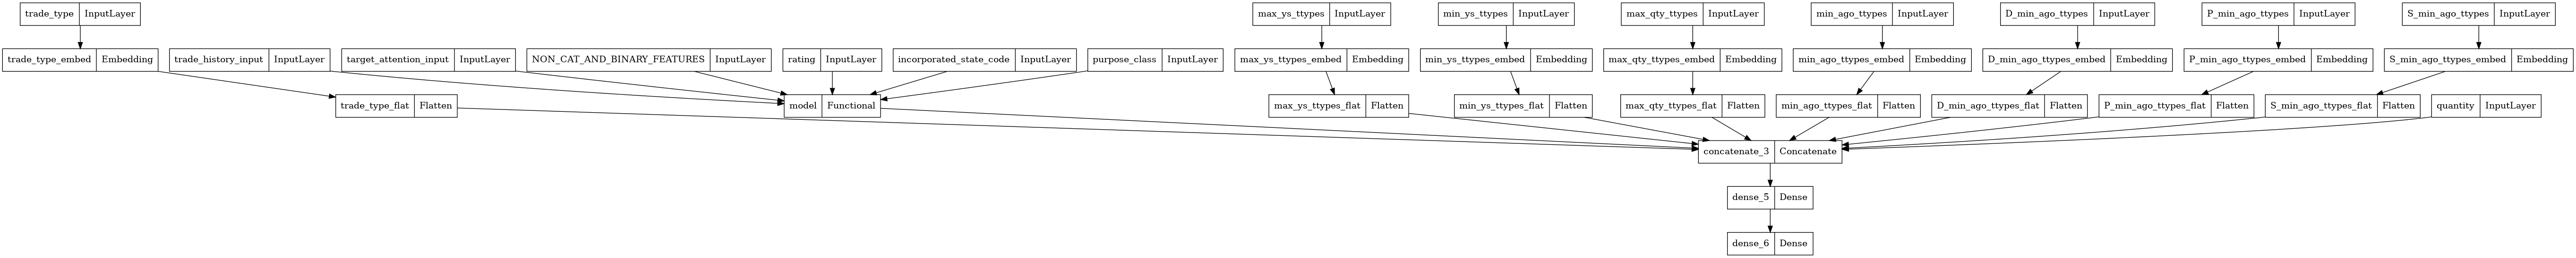

In [39]:
keras.utils.plot_model(ytw_result[0][1])

In [102]:
synthetic_test = test_dataframe[test_dataframe.trade_type!='D'][PREDICTORS+['cusip', 'trade_type', 'quantity', 'trade_datetime', 'new_ys']].sort_values('trade_datetime', ascending=True).copy()
synthetic_test = synthetic_test.drop_duplicates(subset=['cusip'], keep='last')
temp = synthetic_test.copy()
temp.trade_type = ['P' if x == 'S' else 'S' for x in temp.trade_type]
inverted_attention = temp.target_attention_features.parallel_apply(invert_attention)
temp.target_attention_features = inverted_attention.values
synthetic_test = pd.concat([synthetic_test, temp], axis=0)
synthetic_test.reset_index(inplace=True, drop=True)

In [ ]:
%%time
temp = synthetic_test[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
synthetic_test[YS_COLS] = pd.DataFrame(temp.tolist(), index=synthetic_test.index)

CPU times: user 6.03 s, sys: 5.68 s, total: 11.7 s
Wall time: 17.1 s


In [ ]:
modify_features(ttype_features, 'add', 'categorical')
modify_features(['quantity'], 'remove', 'numeric')

In [ ]:
x_test_2 = create_input_2(synthetic_test, trade_history_col, yield_history_cols)
synthetic_test['ahmad_prediction'] = new_model.predict(x_test_2, batch_size=20000)

KeyboardInterrupt: 

In [ ]:
BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',
          'extraordinary_make_whole_call',
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'purpose_class',
                        'max_ys_ttypes',
                        'min_ys_ttypes',
                        'max_qty_ttypes',
                        'min_ago_ttypes',
                        'D_min_ago_ttypes',
                        'P_min_ago_ttypes',
                        'S_min_ago_ttypes']

NON_CAT_FEATURES = ['days_to_maturity',
                     'days_to_call',
                     'coupon',
                     'issue_amount',
                     'last_seconds_ago',
                     'last_yield_spread',
                     'days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price',
                     'orig_principal_amount',
                     'max_amount_outstanding',
                     'accrued_days',
                     'days_in_interest_payment',
                     'A/E',
                     'ficc_treasury_spread',
                     'max_ys_ys',
                     'max_ys_ago',
                     'max_ys_qdiff',
                     'min_ys_ys',
                     'min_ys_ago',
                     'min_ys_qdiff',
                     'max_qty_ys',
                     'max_qty_ago',
                     'max_qty_qdiff',
                     'min_ago_ys',
                     'min_ago_ago',
                     'min_ago_qdiff',
                     'D_min_ago_ys',
                     'D_min_ago_ago',
                     'D_min_ago_qdiff',
                     'P_min_ago_ys',
                     'P_min_ago_ago',
                     'P_min_ago_qdiff',
                     'S_min_ago_ys',
                     'S_min_ago_ago',
                     'S_min_ago_qdiff']

In [ ]:
x_test_2 = create_input_2(test_dataframe, trade_history_col, yield_history_cols)
pred = new_model.predict(x_test_2, batch_size=20000)

In [ ]:
test_dataframe['prediction'] = pred
test_dataframe['error'] = test_dataframe['prediction'] - test_dataframe.new_ys

In [190]:
t = test_dataframe #[short_filter]
mean_absolute_error(t[~t.last_yield_spread_missing]['prediction'], t[~t.last_yield_spread_missing]['new_ys'])

9.747503797835247

In [185]:
mean_absolute_error(test_dataframe['prediction'], test_dataframe['new_ys'])

11.390188838451984

In [ ]:
mean_absolute_error(test_dataframe[short_filter]['prediction'], test_dataframe[short_filter]['new_ys'])

9.70396901561102

In [ ]:
abs(test_dataframe[short_filter].error).median()

5.040952704552581

In [ ]:
modify_features(ttype_features, 'remove', 'categorical')
modify_features(['quantity'], 'remove', 'numeric')

In [ ]:
x_test_4 = create_input_4(synthetic_test, trade_history_col, yield_history_cols)
synthetic_test['prediction'] = ytw_result[0][1].predict(x_test_4, batch_size=20000)

In [ ]:
mean_absolute_error(synthetic_test.iloc[:len(synthetic_test)//2].ahmad_prediction, synthetic_test.iloc[:len(synthetic_test)//2].new_ys)

18.86369314826577

In [ ]:
mean_absolute_error(synthetic_test.iloc[:len(synthetic_test)//2].prediction, synthetic_test.iloc[:len(synthetic_test)//2].new_ys)

11.16716459433895

In [ ]:
summary_df = make_summary(synthetic_test, prediction_col='ahmad_prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

Prediction col: ahmad_prediction


13408

In [ ]:
summary_df = make_summary(synthetic_test, prediction_col='prediction' , groupbycol = 'cusip')
sum(summary_df.Diff < 0)

Prediction col: prediction


162